In [22]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.transforms import ScaledTranslation
import seaborn as sns
from scipy.stats import spearmanr

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
import random
from sklearn.metrics import make_scorer, recall_score, f1_score, precision_score, roc_auc_score, average_precision_score, precision_recall_curve, auc, fbeta_score

from sklearn.metrics import confusion_matrix
import re
import shap
from sklearn.exceptions import UndefinedMetricWarning
import warnings
import sys
import pickle

#### Version Information

In [23]:
print("Python version:", sys.version)

Python version: 3.12.5 | packaged by conda-forge | (main, Aug  8 2024, 18:24:51) [MSC v.1940 64 bit (AMD64)]


In [24]:
print("NumPy version:", np.__version__)
print("Pandas version:", pd.__version__)

NumPy version: 1.26.4
Pandas version: 2.2.2


In [25]:
!pip list

Package                   Version
------------------------- --------------
anyio                     4.4.0
argon2-cffi               23.1.0
argon2-cffi-bindings      21.2.0
arrow                     1.3.0
asttokens                 2.4.1
async-lru                 2.0.4
attrs                     24.2.0
Babel                     2.14.0
beautifulsoup4            4.12.3
bleach                    6.1.0
Brotli                    1.1.0
cached-property           1.5.2
certifi                   2024.8.30
cffi                      1.17.1
chardet                   5.2.0
charset-normalizer        3.3.2
cloudpickle               3.0.0
colorama                  0.4.6
comm                      0.2.2
contourpy                 1.3.0
cycler                    0.12.1
debugpy                   1.8.5
decorator                 5.1.1
defusedxml                0.7.1
entrypoints               0.4
et-xmlfile                1.1.0
exceptiongroup            1.2.2
executing                 2.1.0
fastjsonschema      

#### Reading in the Dataset

In [26]:
#df as dataset
df = pd.read_excel(r"C:\Users\miaox\Desktop\Coding\DATA1030-Fall2024\Independant Project\wildfire_frequency\sheffield_wildfire_and_climate .xlsx")

In [27]:
#rename df as df_features for feature engineering
df_features = df.copy()

In [28]:
#Generating 'year_month' feature 
df_features['year_month'] = df_features['year'].astype(str) + '_' + df_features['month'].astype(str).str.zfill(2)

In [29]:
#lags
#1, 6 & 12-month lag features for tmax & totalrain 

variables = ['tmax_degC', 'tmin_degC', 'totalrain_mm']
lags = [1, 6, 12]

for var in variables:
    for lag in lags:
        df_features[f'{var}_lag_{lag}'] = df_features[var].shift(lag)

In [30]:
#rolling 4 month average
df_features['totalrain_mm_avg4'] = df_features['totalrain_mm'].shift(1).rolling(window=4, min_periods=1).mean()
df_features['tmax_degC_avg4'] = df_features['tmax_degC'].shift(1).rolling(window=4, min_periods=1).mean()
df_features['tmin_degC_avg4'] = df_features['tmin_degC'].shift(1).rolling(window=4, min_periods=1).mean()

#confirm rolling average is calculated correctly
print(df_features[['totalrain_mm', 'totalrain_mm_avg4']].head(10))

   totalrain_mm  totalrain_mm_avg4
0          16.2                NaN
1          79.9          16.200000
2          16.6          48.050000
3          16.9          37.566667
4          17.3          32.400000
5         134.9          32.675000
6         127.7          46.425000
7          32.4          74.200000
8          75.3          78.075000
9         113.8          92.575000


In [31]:
#convert 'year_month' to datetime and extract 'year' and 'month' features
df_features['year_month_dt'] = pd.to_datetime(df_features['year_month'], format='%Y_%m')
df_features['year'] = df_features['year_month_dt'].dt.year
df_features['month'] = df_features['year_month_dt'].dt.month

#feature 'month_sin' and 'month_cos'
df_features['month_sin'] = np.sin(2 * np.pi * df_features['month'] / 12)
df_features['month_cos'] = np.cos(2 * np.pi * df_features['month'] / 12)

df_features.drop(columns=['year_month_dt'], inplace=True)

#verify features
print("Final columns:")
print(df_features.columns.tolist())  

Final columns:
['year', 'month', 'tmax_degC', 'tmin_degC', 'airfrost_days', 'totalrain_mm', 'totalsun_hours', 'wildfire_quantity', 'year_month', 'tmax_degC_lag_1', 'tmax_degC_lag_6', 'tmax_degC_lag_12', 'tmin_degC_lag_1', 'tmin_degC_lag_6', 'tmin_degC_lag_12', 'totalrain_mm_lag_1', 'totalrain_mm_lag_6', 'totalrain_mm_lag_12', 'totalrain_mm_avg4', 'tmax_degC_avg4', 'tmin_degC_avg4', 'month_sin', 'month_cos']


In [32]:
#rename to wildfire_frequency 
df_features.rename(columns={'wildfire_quantity': 'wildfire_frequency'}, inplace=True)

In [33]:
df_features_binary = df_features.copy() 

In [34]:
df_features_binary['wildfire_frequency'] = df_features_binary['wildfire_frequency'].apply(lambda x: 1 if x > 0 else 0)

In [35]:
#confirm binary feature
print(df_features_binary.columns.tolist())
print(df_features_binary['wildfire_frequency'])

['year', 'month', 'tmax_degC', 'tmin_degC', 'airfrost_days', 'totalrain_mm', 'totalsun_hours', 'wildfire_frequency', 'year_month', 'tmax_degC_lag_1', 'tmax_degC_lag_6', 'tmax_degC_lag_12', 'tmin_degC_lag_1', 'tmin_degC_lag_6', 'tmin_degC_lag_12', 'totalrain_mm_lag_1', 'totalrain_mm_lag_6', 'totalrain_mm_lag_12', 'totalrain_mm_avg4', 'tmax_degC_avg4', 'tmin_degC_avg4', 'month_sin', 'month_cos']
0      0
1      1
2      1
3      1
4      1
      ..
532    0
533    0
534    0
535    0
536    0
Name: wildfire_frequency, Length: 537, dtype: int64


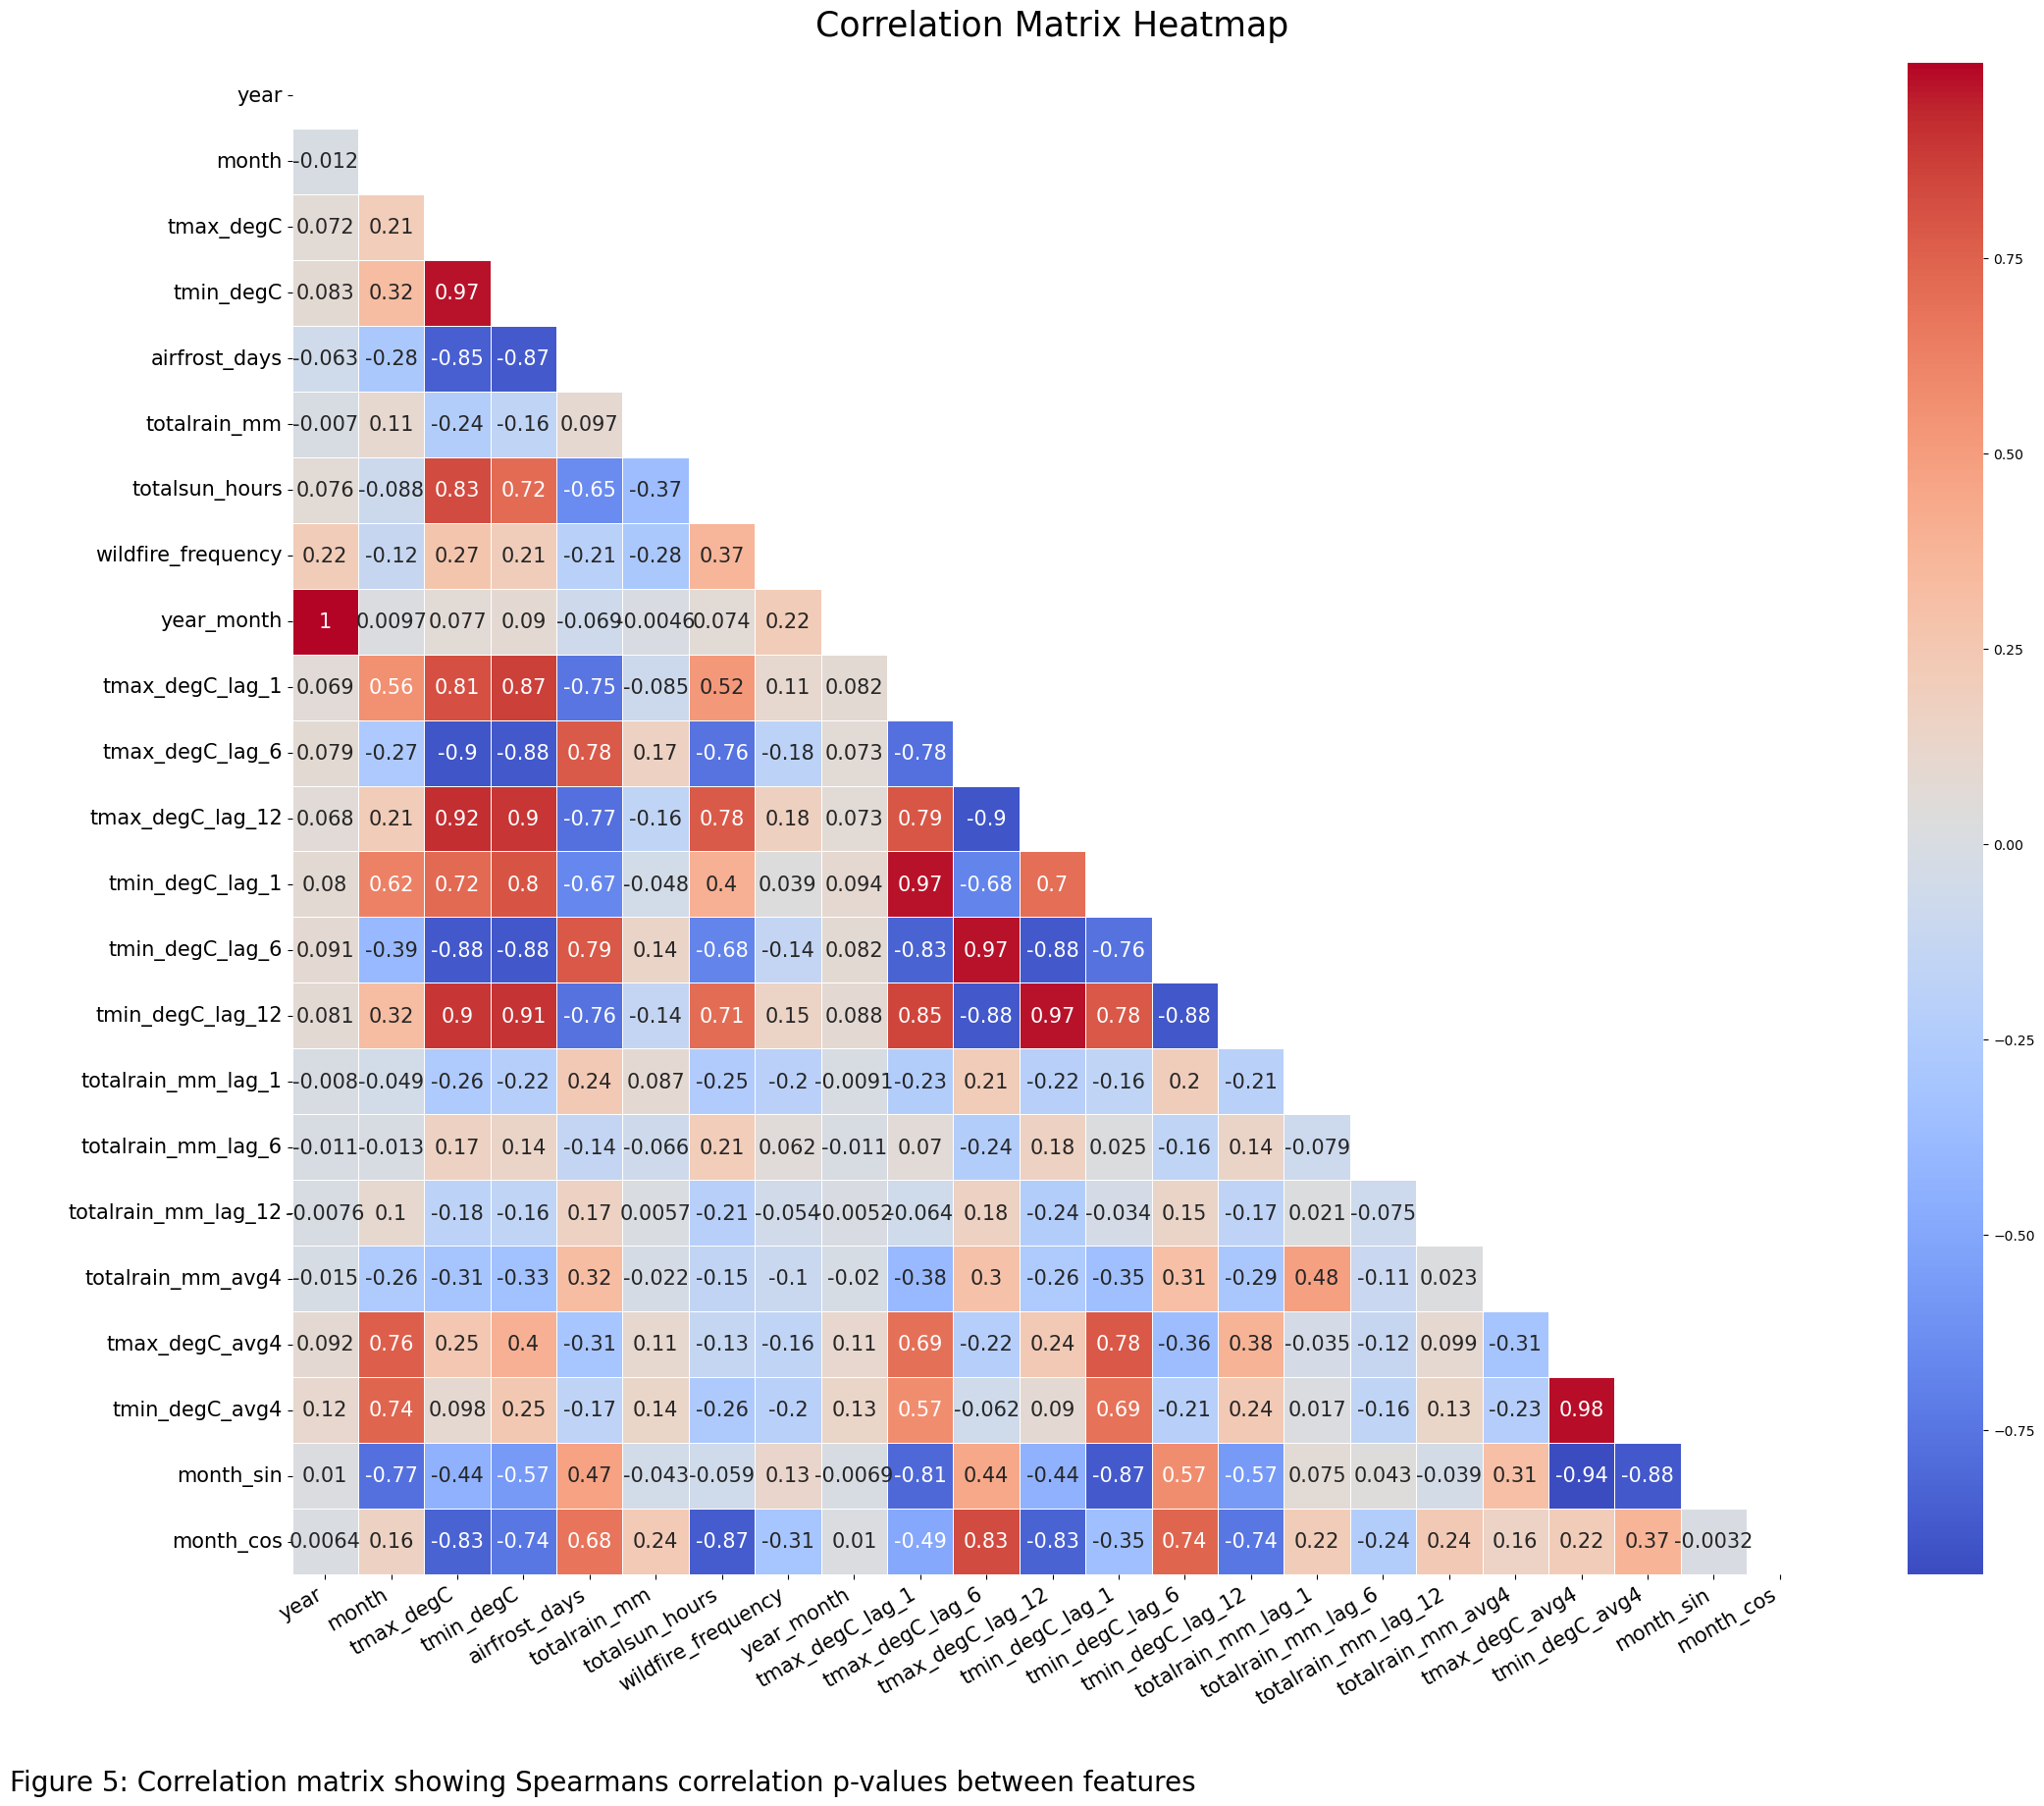

In [36]:
#spearman correlation coeffifient matrix
corr_matrix = df_features_binary.corr(method='spearman')

#create mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(25, 20))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', linewidths=0.5, annot_kws={"size": 15})
plt.title('Correlation Matrix Heatmap', size=25, pad=20)
plt.xticks(size=15, ha='right', rotation=30)  # Slight rotation for readability
plt.yticks(size=15, rotation=0)
plt.figtext(0.01, 0, 'Figure 5: Correlation matrix showing Spearmans correlation p-values between features', size=20)

plt.show()

In [37]:

df_features_binary.drop(columns=['tmin_degC', 'tmin_degC_lag_1', 'tmin_degC_lag_6', 'tmin_degC_lag_12', 'tmin_degC_avg4'], inplace=True)

In [38]:
#indicating missing values in response to lag features
missing_values = df_features_binary.isnull().sum()
print(missing_values)

year                    0
month                   0
tmax_degC               0
airfrost_days           0
totalrain_mm            0
totalsun_hours          0
wildfire_frequency      0
year_month              0
tmax_degC_lag_1         1
tmax_degC_lag_6         6
tmax_degC_lag_12       12
totalrain_mm_lag_1      1
totalrain_mm_lag_6      6
totalrain_mm_lag_12    12
totalrain_mm_avg4       1
tmax_degC_avg4          1
month_sin               0
month_cos               0
dtype: int64


In [39]:
# filter df for date_month 12 months after the start (1977_03) to excluding missing values
df_binary_no_missing_values = df_features_binary[df_features_binary['year_month'] > '1977_03']

In [40]:
df_binary_no_missing_values = df_binary_no_missing_values.drop(columns=['year_month'])

In [41]:
#indicating missing values in response to lag features
missing_values = df_binary_no_missing_values.isnull().sum()
print(missing_values)

year                   0
month                  0
tmax_degC              0
airfrost_days          0
totalrain_mm           0
totalsun_hours         0
wildfire_frequency     0
tmax_degC_lag_1        0
tmax_degC_lag_6        0
tmax_degC_lag_12       0
totalrain_mm_lag_1     0
totalrain_mm_lag_6     0
totalrain_mm_lag_12    0
totalrain_mm_avg4      0
tmax_degC_avg4         0
month_sin              0
month_cos              0
dtype: int64


In [42]:
Y = df_binary_no_missing_values['wildfire_frequency']
X = df_binary_no_missing_values.drop(columns=['wildfire_frequency'])

In [43]:
print(Y)

12     0
13     1
14     0
15     0
16     0
      ..
532    0
533    0
534    0
535    0
536    0
Name: wildfire_frequency, Length: 525, dtype: int64


#### Logistic Regression


Fold 1:
  Training set: X shape = (90, 16), Y shape = (90,), Size = 90
  Validation set:  X shape = (43, 16), Y shape = (43,), Size = 43
  Testing set:  X shape = (44, 16), Y shape = (44,), Size = 44

Fold 1 - Class Distribution in Test Set:
  Total samples: 44
  Class Counts:
wildfire_frequency
0    38
1     6
Name: count, dtype: int64
  Majority Class: 0
  Majority Class Count: 38

Baseline Metric Calculations:
  Accuracy: 0.13636363636363635
  Precision: 0.13636363636363635
  Recall: 1
  F1 Score: 0.24000000000000002
  F1.5 Score: 0.3391304347826087
  PR AUC: 0.13636363636363635
Fitting 5 folds for each of 168 candidates, totalling 840 fits
Fold 1 -> Best Params: {'model__C': 0.06309573444801933, 'model__penalty': 'l2', 'model__solver': 'saga'}


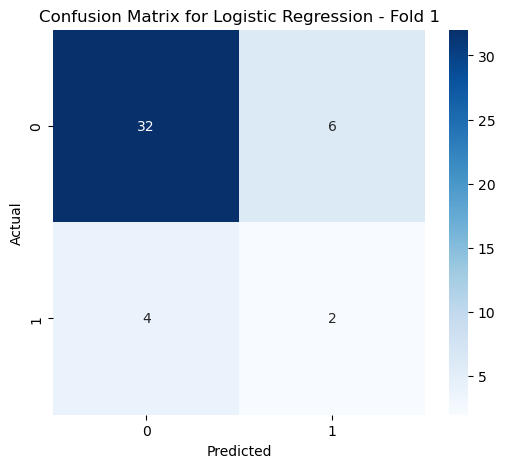

  Train Accuracy: 0.8667
  Validation Accuracy: 0.8837
  Test Accuracy: 0.7727
  Train F-beta Score: 0.5200
  Validation F-beta Score: 0.0000
  Test F-beta Score: 0.3023
  Train F1 Score: 0.4000
  Validation F1 Score: 0.0000
  Test F1 Score: 0.2857
  Train Recall: 1.0000
  Validation Recall: 0.0000
  Test Recall: 0.3333
  Train Precision: 0.2500
  Validation Precision: 0.0000
  Test Precision: 0.2500
  Train PR AUC: 0.6250
  Validation PR AUC: 0.5000
  Test PR AUC: 0.3371

Fold 2:
  Training set: X shape = (177, 16), Y shape = (177,), Size = 177
  Validation set:  X shape = (43, 16), Y shape = (43,), Size = 43
  Testing set:  X shape = (44, 16), Y shape = (44,), Size = 44

Fold 2 - Class Distribution in Test Set:
  Total samples: 44
  Class Counts:
wildfire_frequency
0    36
1     8
Name: count, dtype: int64
  Majority Class: 0
  Majority Class Count: 36

Baseline Metric Calculations:
  Accuracy: 0.18181818181818182
  Precision: 0.18181818181818182
  Recall: 1
  F1 Score: 0.30769230769

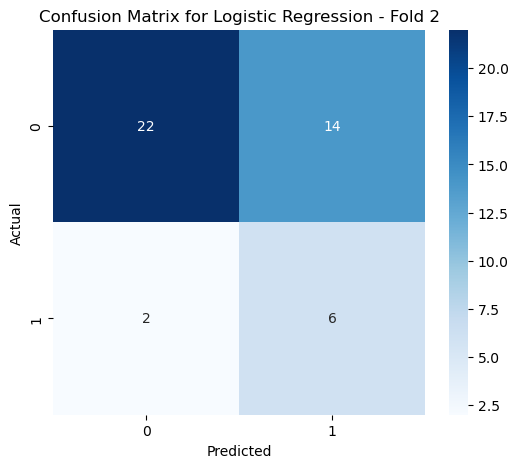

  Train Accuracy: 0.8192
  Validation Accuracy: 0.8140
  Test Accuracy: 0.6364
  Train F-beta Score: 0.4680
  Validation F-beta Score: 0.7597
  Test F-beta Score: 0.5132
  Train F1 Score: 0.3600
  Validation F1 Score: 0.6923
  Test F1 Score: 0.4286
  Train Recall: 0.9000
  Validation Recall: 0.9000
  Test Recall: 0.7500
  Train Precision: 0.2250
  Validation Precision: 0.5625
  Test Precision: 0.3000
  Train PR AUC: 0.5653
  Validation PR AUC: 0.7429
  Test PR AUC: 0.5477

Fold 3:
  Training set: X shape = (264, 16), Y shape = (264,), Size = 264
  Validation set:  X shape = (43, 16), Y shape = (43,), Size = 43
  Testing set:  X shape = (44, 16), Y shape = (44,), Size = 44

Fold 3 - Class Distribution in Test Set:
  Total samples: 44
  Class Counts:
wildfire_frequency
0    31
1    13
Name: count, dtype: int64
  Majority Class: 0
  Majority Class Count: 31

Baseline Metric Calculations:
  Accuracy: 0.29545454545454547
  Precision: 0.29545454545454547
  Recall: 1
  F1 Score: 0.45614035087

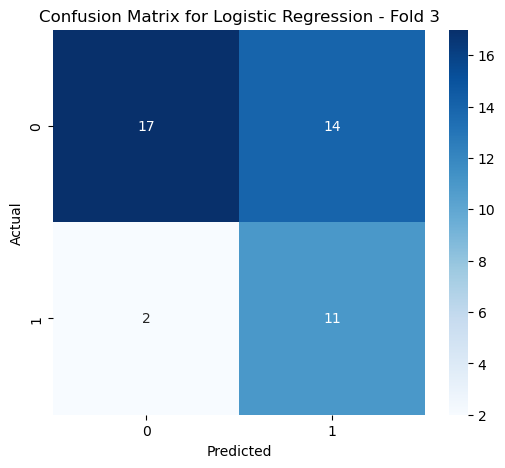

  Train Accuracy: 0.7462
  Validation Accuracy: 0.6512
  Test Accuracy: 0.6364
  Train F-beta Score: 0.5345
  Validation F-beta Score: 0.6341
  Test F-beta Score: 0.6590
  Train F1 Score: 0.4274
  Validation F1 Score: 0.5161
  Test F1 Score: 0.5789
  Train Recall: 0.8929
  Validation Recall: 1.0000
  Test Recall: 0.8462
  Train Precision: 0.2809
  Validation Precision: 0.3478
  Test Precision: 0.4400
  Train PR AUC: 0.5926
  Validation PR AUC: 0.6739
  Test PR AUC: 0.6658

Fold 4:
  Training set: X shape = (351, 16), Y shape = (351,), Size = 351
  Validation set:  X shape = (43, 16), Y shape = (43,), Size = 43
  Testing set:  X shape = (44, 16), Y shape = (44,), Size = 44

Fold 4 - Class Distribution in Test Set:
  Total samples: 44
  Class Counts:
wildfire_frequency
0    33
1    11
Name: count, dtype: int64
  Majority Class: 0
  Majority Class Count: 33

Baseline Metric Calculations:
  Accuracy: 0.25
  Precision: 0.25
  Recall: 1
  F1 Score: 0.4
  F1.5 Score: 0.52
  PR AUC: 0.25
Fitti

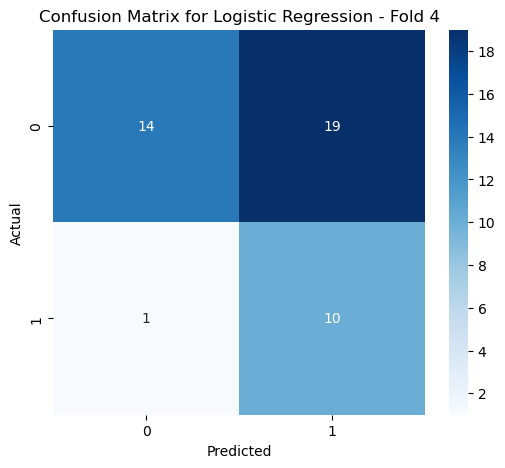

  Train Accuracy: 0.7521
  Validation Accuracy: 0.6512
  Test Accuracy: 0.5455
  Train F-beta Score: 0.5877
  Validation F-beta Score: 0.6714
  Test F-beta Score: 0.6047
  Train F1 Score: 0.4912
  Validation F1 Score: 0.5946
  Test F1 Score: 0.5000
  Train Recall: 0.8571
  Validation Recall: 0.8462
  Test Recall: 0.9091
  Train Precision: 0.3443
  Validation Precision: 0.4583
  Test Precision: 0.3448
  Train PR AUC: 0.6107
  Validation PR AUC: 0.6755
  Test PR AUC: 0.6383

Fold 5:
  Training set: X shape = (438, 16), Y shape = (438,), Size = 438
  Validation set:  X shape = (43, 16), Y shape = (43,), Size = 43
  Testing set:  X shape = (44, 16), Y shape = (44,), Size = 44

Fold 5 - Class Distribution in Test Set:
  Total samples: 44
  Class Counts:
wildfire_frequency
0    28
1    16
Name: count, dtype: int64
  Majority Class: 0
  Majority Class Count: 28

Baseline Metric Calculations:
  Accuracy: 0.36363636363636365
  Precision: 0.36363636363636365
  Recall: 1
  F1 Score: 0.53333333333

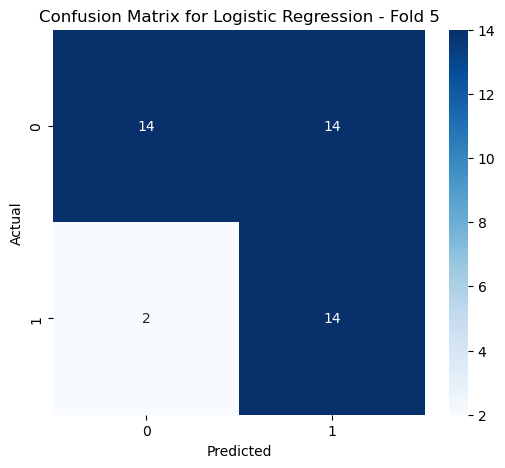

  Train Accuracy: 0.7443
  Validation Accuracy: 0.5814
  Test Accuracy: 0.6364
  Train F-beta Score: 0.5969
  Validation F-beta Score: 0.6436
  Test F-beta Score: 0.7109
  Train F1 Score: 0.5130
  Validation F1 Score: 0.5263
  Test F1 Score: 0.6364
  Train Recall: 0.8082
  Validation Recall: 1.0000
  Test Recall: 0.8750
  Train Precision: 0.3758
  Validation Precision: 0.3571
  Test Precision: 0.5000
  Train PR AUC: 0.6080
  Validation PR AUC: 0.6786
  Test PR AUC: 0.7102

Overall Metrics:
Accuracy - Train: Mean = 0.7857, Std Dev = 0.0550
Accuracy - Validation: Mean = 0.7163, Std Dev = 0.1267
Accuracy - Test: Mean = 0.6455, Std Dev = 0.0813
F-beta Score - Train: Mean = 0.5414, Std Dev = 0.0527
F-beta Score - Validation: Mean = 0.5418, Std Dev = 0.3069
F-beta Score - Test: Mean = 0.5580, Std Dev = 0.1606
F1 Score - Train: Mean = 0.4383, Std Dev = 0.0635
F1 Score - Validation: Mean = 0.4659, Std Dev = 0.2697
F1 Score - Test: Mean = 0.4859, Std Dev = 0.1368
Recall - Train: Mean = 0.8916, 

In [44]:
# new logistic regression with validation
#f1 scorer
f1_scorer = make_scorer(f1_score)

# param_grid
param_grid = {
    'model__C': np.logspace(-2, 2, 21), 
    'model__penalty': ['l2', None],
    'model__solver': ['saga', 'sag', 'lbfgs', 'newton-cg']
}

metrics = {
    "Accuracy": accuracy_score,
    "F-beta Score": lambda y_true, y_pred: fbeta_score(y_true, y_pred, beta=1.5),
    "F1 Score": f1_score,
    "Recall": recall_score,
    "Precision": precision_score,
    "PR AUC": lambda y_true, y_pred: compute_pr_auc(y_true, y_pred)
}

tscv = TimeSeriesSplit(n_splits=5)

def compute_pr_auc(y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    pr_auc = auc(recall, precision)
    return pr_auc

best_models_logistic_regression = []

class_distributions = {}
logistic_regression_baseline_metrics = {}
logistic_regression_means = {}
logistic_regression_stds = {}

#consistently format metric names
def format_metric_name(metric_name):
    return re.sub(r'[^a-zA-Z0-9]+', '_', metric_name.lower())

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
    
#initialise scores dictionaries
scores_per_fold = {f"train_{format_metric_name(name)}": [] for name in metrics}
scores_per_fold.update({f"test_{format_metric_name(name)}": [] for name in metrics})
scores_per_fold.update({f"val_{format_metric_name(name)}": [] for name in metrics})  # Add validation scores

# data splitting, model training, & evaluation
for fold_idx, (train_index, test_index) in enumerate(tscv.split(X), start=1):
    # Split data into train and test sets
    X_train = X.iloc[train_index]
    Y_train = Y.iloc[train_index]
    X_test_full = X.iloc[test_index]
    Y_test_full = Y.iloc[test_index]

    #split the test set into 10% validation and 10% test (chronologically)
    split_point = len(X_test_full) // 2
    X_val = X_test_full.iloc[:split_point]
    Y_val = Y_test_full.iloc[:split_point]
    
    X_test = X_test_full.iloc[split_point:]
    Y_test = Y_test_full.iloc[split_point:]

    print(f"\nFold {fold_idx}:")
    print(f"  Training set: X shape = {X_train.shape}, Y shape = {Y_train.shape}, Size = {X_train.shape[0]}")
    print(f"  Validation set:  X shape = {X_val.shape}, Y shape = {Y_val.shape}, Size = {X_val.shape[0]}")
    print(f"  Testing set:  X shape = {X_test.shape}, Y shape = {Y_test.shape}, Size = {X_test.shape[0]}")
    
    #count class occurrences in Y_test
    class_counts = Y_test.value_counts()
    total = len(Y_test)
    majority_class = class_counts.idxmax()
    majority_class_count = class_counts.max()
    num_class_1 = class_counts.get(1, 0)
    num_class_0 = class_counts.get(0, 0)
    baseline_probs = [1 if majority_class == 1 else 0] * len(Y_test)
    precision_baseline, recall_baseline, _ = precision_recall_curve(Y_test, baseline_probs)

    # debugging prints for class distribution
    print(f"\nFold {fold_idx} - Class Distribution in Test Set:")
    print(f"  Total samples: {total}")
    print(f"  Class Counts:\n{class_counts}")
    print(f"  Majority Class: {majority_class}")
    print(f"  Majority Class Count: {majority_class_count}")
    
   # store class distribution
    class_distributions[fold_idx] = {
        "Class 0": num_class_0,
        "Class 1": num_class_1
    }

    accuracy = num_class_1 / (num_class_1 + num_class_0)
    precision = num_class_1 / (num_class_1 + num_class_0)
    recall = 1
    f1 = (2*precision*recall) / (precision+recall)
    f1_5 = (3.25*precision*recall) / ((2.25*precision) + recall)
    pr_auc = num_class_1 / (num_class_1 + num_class_0)

    print("\nBaseline Metric Calculations:")
    print(f"  Accuracy: {accuracy}")
    print(f"  Precision: {precision}")
    print(f"  Recall: {recall}")
    print(f"  F1 Score: {f1}")
    print(f"  F1.5 Score: {f1_5}")
    print(f"  PR AUC: {pr_auc}")
    
    logistic_regression_baseline_metrics[fold_idx] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "F1.5": f1_5,
        "PR AUC": pr_auc
    }
    
    # pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  
        ('model', LogisticRegression(class_weight='balanced', max_iter=1000, tol=1e-4, random_state=1))
    ])
    
    # GridSearchCV with tscv
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=tscv,
        scoring=f1_scorer,
        refit=True,  # refit best model on the full training data
        n_jobs=-1,  
        verbose=1
    )
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        grid_search.fit(X_train, Y_train)
    
    # use the validation set to select the best model
    best_model_idx = np.argmax([grid_search.score(X_val, Y_val) for model in grid_search.cv_results_['params']])

    # find best parameters using X_train
    best_params = grid_search.best_params_
    best_model_logistic_regression = grid_search.best_estimator_
    print(f"Fold {fold_idx} -> Best Params: {best_params}")

    # evaluate best model on the validation set (X_val, Y_val)
    y_val_pred_probs = best_model_logistic_regression.predict_proba(X_val)[:, 1]
    y_val_pred = best_model_logistic_regression.predict(X_val)

    #evalualte on X_train 
    y_train_pred = best_model_logistic_regression.predict(X_train)

    # evaluate on X_test
    y_test_pred_probs = best_model_logistic_regression.predict_proba(X_test)[:, 1]
    y_test_pred = best_model_logistic_regression.predict(X_test)

    # predict probabilities (needed for PR AUC calculation)
    y_pred_probs = best_model_logistic_regression.predict_proba(X_test)[:, 1]  # Get probabilities for class 1
    
    # calculate PR AUC for the test set
    pr_auc_value = compute_pr_auc(Y_test, y_pred_probs)

    #generate confusion matrix for each fold
    cm = confusion_matrix(Y_test, y_test_pred, labels=[0, 1])
        
    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix for Logistic Regression - Fold {fold_idx}")
    plt.show()
    
    #for loop for calculating train & test metrics
    #print(f"Fold {fold_idx} metrics:")
    for name, func in metrics.items():
        formatted_name = format_metric_name(name)

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
    
            # Train metrics
            train_score = func(Y_train, y_train_pred)
            print(f"  Train {name}: {train_score:.4f}")
            scores_per_fold[f"train_{formatted_name}"].append(train_score)
    
            # Validation metrics
            val_score = func(Y_val, y_val_pred)
            print(f"  Validation {name}: {val_score:.4f}")
            scores_per_fold[f"val_{formatted_name}"].append(val_score)
            
            # Test metrics
            test_score = func(Y_test, y_test_pred)
            print(f"  Test {name}: {test_score:.4f}")
            scores_per_fold[f"test_{formatted_name}"].append(test_score)

# calculate and save mean and std metrics
print("\nOverall Metrics:")
for metric_name in metrics:
    formatted_name = format_metric_name(metric_name)
    train_key = f"train_{formatted_name}"
    val_key = f"val_{formatted_name}"
    test_key = f"test_{formatted_name}"
    
    avg_train = np.mean(scores_per_fold[train_key])
    std_train = np.std(scores_per_fold[train_key], ddof=1)
    avg_val = np.mean(scores_per_fold[val_key])
    std_val = np.std(scores_per_fold[val_key], ddof=1)
    avg_test = np.mean(scores_per_fold[test_key])
    std_test = np.std(scores_per_fold[test_key], ddof=1)

    # save to dictionaries for model comparison
    logistic_regression_means[f"logistic_regression_{formatted_name}_mean"] = {
        "train": avg_train,
        "val": avg_val,
        "test": avg_test
    }
    logistic_regression_stds[f"logistic_regression_{formatted_name}_std"] = {
        "train": std_train,
        "val": std_val,
        "test": std_test
    }
        
    print(f"{metric_name} - Train: Mean = {avg_train:.4f}, Std Dev = {std_train:.4f}")
    print(f"{metric_name} - Validation: Mean = {avg_val:.4f}, Std Dev = {std_val:.4f}")
    print(f"{metric_name} - Test: Mean = {avg_test:.4f}, Std Dev = {std_test:.4f}")

#print baselines at the end for each fold:
print("\nBaseline Metrics per Fold:")
for fold, metrics in logistic_regression_baseline_metrics.items():
    print(f"Fold {fold}: {metrics}")

#### XGBoost


Fold 1:
  Training set: X shape = (90, 16), Y shape = (90,), Size = 90
  Validation set:  X shape = (43, 16), Y shape = (43,), Size = 43
  Testing set:  X shape = (44, 16), Y shape = (44,), Size = 44

Fold 1 - Class Distribution in Test Set:
  Total samples: 44
  Class Counts:
wildfire_frequency
0    38
1     6
Name: count, dtype: int64
  Majority Class: 0
  Majority Class Count: 38

Baseline Metric Calculations:
  Accuracy: 0.13636363636363635
  Precision: 0.13636363636363635
  Recall: 1
  F1 Score: 0.24000000000000002
  F1.5 Score: 0.3391304347826087
  PR AUC: 0.13636363636363635
Fitting 5 folds for each of 144 candidates, totalling 720 fits
Fold 1 -> Best Params: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__n_estimators': 100, 'model__reg_alpha': 0, 'model__reg_lambda': 0.1, 'model__subsample': 0.8}


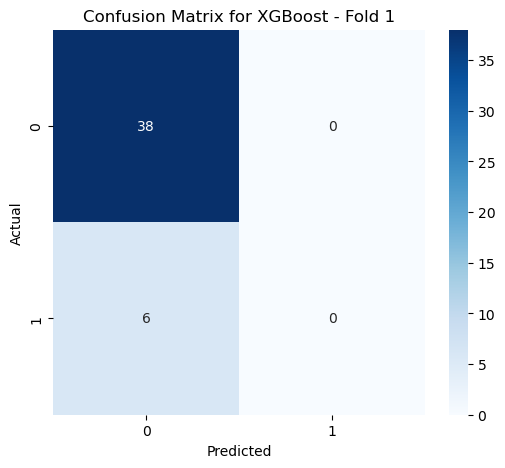

  Train Accuracy: 0.9778
  Validation Accuracy: 0.9535
  Test Accuracy: 0.8636
  Train F-beta Score: 0.8667
  Validation F-beta Score: 0.0000
  Test F-beta Score: 0.0000
  Train F1 Score: 0.8000
  Validation F1 Score: 0.0000
  Test F1 Score: 0.0000
  Train Recall: 1.0000
  Validation Recall: 0.0000
  Test Recall: 0.0000
  Train Precision: 0.6667
  Validation Precision: 0.0000
  Test Precision: 0.0000
  Train PR AUC: 0.8333
  Validation PR AUC: 0.5000
  Test PR AUC: 0.5682

Fold 2:
  Training set: X shape = (177, 16), Y shape = (177,), Size = 177
  Validation set:  X shape = (43, 16), Y shape = (43,), Size = 43
  Testing set:  X shape = (44, 16), Y shape = (44,), Size = 44

Fold 2 - Class Distribution in Test Set:
  Total samples: 44
  Class Counts:
wildfire_frequency
0    36
1     8
Name: count, dtype: int64
  Majority Class: 0
  Majority Class Count: 36

Baseline Metric Calculations:
  Accuracy: 0.18181818181818182
  Precision: 0.18181818181818182
  Recall: 1
  F1 Score: 0.30769230769

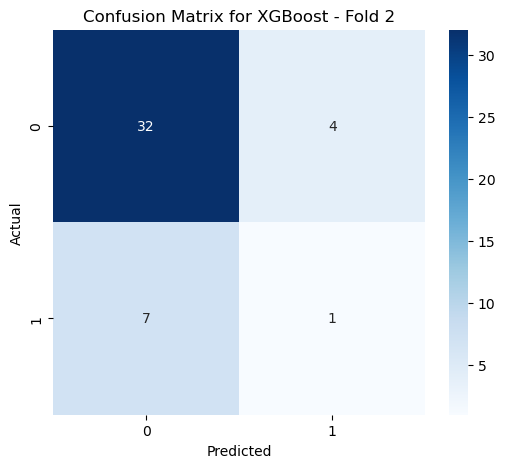

  Train Accuracy: 0.9492
  Validation Accuracy: 0.6977
  Test Accuracy: 0.7500
  Train F-beta Score: 0.7831
  Validation F-beta Score: 0.0000
  Test F-beta Score: 0.1413
  Train F1 Score: 0.6897
  Validation F1 Score: 0.0000
  Test F1 Score: 0.1538
  Train Recall: 1.0000
  Validation Recall: 0.0000
  Test Recall: 0.1250
  Train Precision: 0.5263
  Validation Precision: 0.0000
  Test Precision: 0.2000
  Train PR AUC: 0.7632
  Validation PR AUC: 0.1163
  Test PR AUC: 0.2420

Fold 3:
  Training set: X shape = (264, 16), Y shape = (264,), Size = 264
  Validation set:  X shape = (43, 16), Y shape = (43,), Size = 43
  Testing set:  X shape = (44, 16), Y shape = (44,), Size = 44

Fold 3 - Class Distribution in Test Set:
  Total samples: 44
  Class Counts:
wildfire_frequency
0    31
1    13
Name: count, dtype: int64
  Majority Class: 0
  Majority Class Count: 31

Baseline Metric Calculations:
  Accuracy: 0.29545454545454547
  Precision: 0.29545454545454547
  Recall: 1
  F1 Score: 0.45614035087

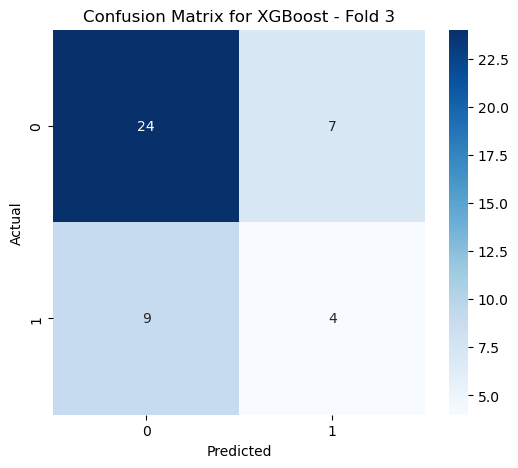

  Train Accuracy: 0.9924
  Validation Accuracy: 0.8140
  Test Accuracy: 0.6364
  Train F-beta Score: 0.9785
  Validation F-beta Score: 0.4062
  Test F-beta Score: 0.3230
  Train F1 Score: 0.9655
  Validation F1 Score: 0.4286
  Test F1 Score: 0.3333
  Train Recall: 1.0000
  Validation Recall: 0.3750
  Test Recall: 0.3077
  Train Precision: 0.9333
  Validation Precision: 0.5000
  Test Precision: 0.3636
  Train PR AUC: 0.9667
  Validation PR AUC: 0.4956
  Test PR AUC: 0.4379

Fold 4:
  Training set: X shape = (351, 16), Y shape = (351,), Size = 351
  Validation set:  X shape = (43, 16), Y shape = (43,), Size = 43
  Testing set:  X shape = (44, 16), Y shape = (44,), Size = 44

Fold 4 - Class Distribution in Test Set:
  Total samples: 44
  Class Counts:
wildfire_frequency
0    33
1    11
Name: count, dtype: int64
  Majority Class: 0
  Majority Class Count: 33

Baseline Metric Calculations:
  Accuracy: 0.25
  Precision: 0.25
  Recall: 1
  F1 Score: 0.4
  F1.5 Score: 0.52
  PR AUC: 0.25
Fitti

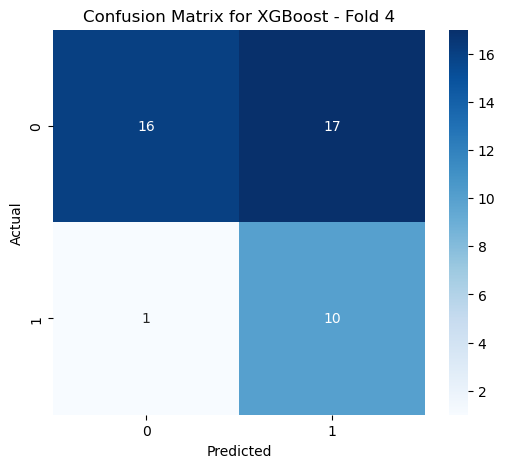

  Train Accuracy: 0.8860
  Validation Accuracy: 0.6512
  Test Accuracy: 0.5909
  Train F-beta Score: 0.7992
  Validation F-beta Score: 0.5939
  Test F-beta Score: 0.6280
  Train F1 Score: 0.7101
  Validation F1 Score: 0.5455
  Test F1 Score: 0.5263
  Train Recall: 1.0000
  Validation Recall: 0.6923
  Test Recall: 0.9091
  Train Precision: 0.5506
  Validation Precision: 0.4500
  Test Precision: 0.3704
  Train PR AUC: 0.7753
  Validation PR AUC: 0.6177
  Test PR AUC: 0.6511

Fold 5:
  Training set: X shape = (438, 16), Y shape = (438,), Size = 438
  Validation set:  X shape = (43, 16), Y shape = (43,), Size = 43
  Testing set:  X shape = (44, 16), Y shape = (44,), Size = 44

Fold 5 - Class Distribution in Test Set:
  Total samples: 44
  Class Counts:
wildfire_frequency
0    28
1    16
Name: count, dtype: int64
  Majority Class: 0
  Majority Class Count: 28

Baseline Metric Calculations:
  Accuracy: 0.36363636363636365
  Precision: 0.36363636363636365
  Recall: 1
  F1 Score: 0.53333333333

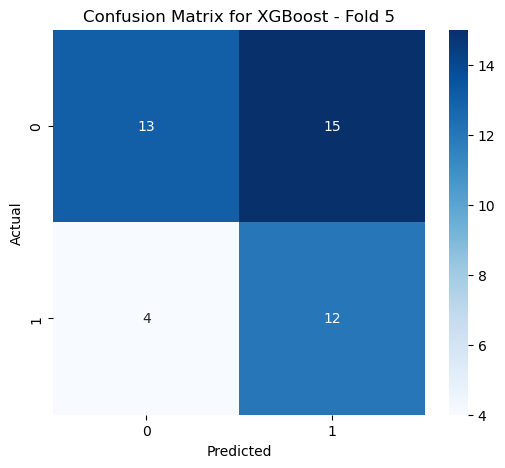

  Train Accuracy: 0.7991
  Validation Accuracy: 0.6047
  Test Accuracy: 0.5682
  Train F-beta Score: 0.7239
  Validation F-beta Score: 0.6158
  Test F-beta Score: 0.6190
  Train F1 Score: 0.6207
  Validation F1 Score: 0.5143
  Test F1 Score: 0.5581
  Train Recall: 0.9863
  Validation Recall: 0.9000
  Test Recall: 0.7500
  Train Precision: 0.4528
  Validation Precision: 0.3600
  Test Precision: 0.4444
  Train PR AUC: 0.7207
  Validation PR AUC: 0.6416
  Test PR AUC: 0.6427

Overall Metrics:
Accuracy - Train: Mean = 0.9209, Std Dev = 0.0794
Accuracy - Validation: Mean = 0.7442, Std Dev = 0.1405
Accuracy - Test: Mean = 0.6818, Std Dev = 0.1234
F-beta Score - Train: Mean = 0.8303, Std Dev = 0.0972
F-beta Score - Validation: Mean = 0.3232, Std Dev = 0.3061
F-beta Score - Test: Mean = 0.3423, Std Dev = 0.2811
F1 Score - Train: Mean = 0.7572, Std Dev = 0.1329
F1 Score - Validation: Mean = 0.2977, Std Dev = 0.2751
F1 Score - Test: Mean = 0.3143, Std Dev = 0.2394
Recall - Train: Mean = 0.9973, 

In [45]:
# XGBoost with validation

# define scorer inside gridsearch
f1_scorer = make_scorer(f1_score)
recall_scorer = make_scorer(recall_score)

# param_grid
param_grid = {
    'model__n_estimators': [100],
    'model__max_depth': [3, 10, 30, 100],
    'model__learning_rate': [0.01],
    'model__reg_alpha': [0, 0.1, 1],
    'model__reg_lambda': [0.1, 1, 10], 
    'model__subsample': [0.8, 0.9],
    'model__colsample_bytree': [0.8, 0.9],
}
metrics = {
    "Accuracy": accuracy_score,
    "F-beta Score": lambda y_true, y_pred: fbeta_score(y_true, y_pred, beta=1.5),
    "F1 Score": f1_score,
    "Recall": recall_score,
    "Precision": precision_score,
    "PR AUC": lambda y_true, y_pred: compute_pr_auc(y_true, y_pred)
}

tscv = TimeSeriesSplit(n_splits=5)

best_models_xgb = []

class_distributions = {}
xgb_baseline_metrics = {}
xgb_means = {}
xgb_stds = {}

# consistently format metric names
def format_metric_name(metric_name):
    return re.sub(r'[^a-zA-Z0-9]+', '_', metric_name.lower())
    
# initialise scores dictionaries
scores_per_fold = {f"train_{format_metric_name(name)}": [] for name in metrics}
scores_per_fold.update({f"test_{format_metric_name(name)}": [] for name in metrics})
scores_per_fold.update({f"val_{format_metric_name(name)}": [] for name in metrics})  # Add validation scores

# data splitting, model training, & evaluation
for fold_idx, (train_index, test_index) in enumerate(tscv.split(X), start=1):
    # Split data into train and test sets
    X_train = X.iloc[train_index]
    Y_train = Y.iloc[train_index]
    X_test_full = X.iloc[test_index]
    Y_test_full = Y.iloc[test_index]

    # split test set into 10% validation and 10% test (chronologically)
    split_point = len(X_test_full) // 2
    X_val = X_test_full.iloc[:split_point]
    Y_val = Y_test_full.iloc[:split_point]
    
    X_test = X_test_full.iloc[split_point:]
    Y_test = Y_test_full.iloc[split_point:]

    print(f"\nFold {fold_idx}:")
    print(f"  Training set: X shape = {X_train.shape}, Y shape = {Y_train.shape}, Size = {X_train.shape[0]}")
    print(f"  Validation set:  X shape = {X_val.shape}, Y shape = {Y_val.shape}, Size = {X_val.shape[0]}")
    print(f"  Testing set:  X shape = {X_test.shape}, Y shape = {Y_test.shape}, Size = {X_test.shape[0]}")

    #defining class imbalance
    scale_pos_weight = len(Y_train[Y_train == 0]) / len(Y_train[Y_train == 1])
    
    # count class occurrences in Y_test
    class_counts = Y_test.value_counts()
    total = len(Y_test)
    majority_class = class_counts.idxmax()
    majority_class_count = class_counts.max()
    num_class_1 = class_counts.get(1, 0)
    num_class_0 = class_counts.get(0, 0)
    baseline_probs = [1 if majority_class == 1 else 0] * len(Y_test)
    precision_baseline, recall_baseline, _ = precision_recall_curve(Y_test, baseline_probs)

    # debugging prints for class distribution
    print(f"\nFold {fold_idx} - Class Distribution in Test Set:")
    print(f"  Total samples: {total}")
    print(f"  Class Counts:\n{class_counts}")
    print(f"  Majority Class: {majority_class}")
    print(f"  Majority Class Count: {majority_class_count}")
    
   # store class distribution
    class_distributions[fold_idx] = {
        "Class 0": num_class_0,
        "Class 1": num_class_1
    }

    #baseline for predicting all class 1
    accuracy = num_class_1 / (num_class_1 + num_class_0)
    precision = num_class_1 / (num_class_1 + num_class_0)
    recall = 1
    f1 = (2*precision*recall) / (precision+recall)
    f1_5 = (3.25*precision*recall) / ((2.25*precision) + recall)
    pr_auc = num_class_1 / (num_class_1 + num_class_0)

    print("\nBaseline Metric Calculations:")
    print(f"  Accuracy: {accuracy}")
    print(f"  Precision: {precision}")
    print(f"  Recall: {recall}")
    print(f"  F1 Score: {f1}")
    print(f"  F1.5 Score: {f1_5}")
    print(f"  PR AUC: {pr_auc}")
    
    xgb_baseline_metrics[fold_idx] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "F1.5": f1_5,
        "PR AUC": pr_auc
    }
    
    # pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  
        ('model', XGBClassifier(use_label_encoder=False, eval_metric='logloss', 
                                scale_pos_weight=scale_pos_weight, random_state=1))
    ])
    
    # GridSearchCV with tscv
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=tscv,
        scoring=f1_scorer,
        refit=True,  # refit best model on the full training data
        n_jobs=-1,  
        verbose=1
    )
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        grid_search.fit(X_train, Y_train)
    
    # Use the validation set to select the best model
    best_model_idx = np.argmax([grid_search.score(X_val, Y_val) for model in grid_search.cv_results_['params']])

    # find best parameters using X_train
    best_params = grid_search.best_params_
    best_model_xgb = grid_search.best_estimator_
    print(f"Fold {fold_idx} -> Best Params: {best_params}")

    # evalualte the best model on the validation set (X_val, Y_val)
    y_val_pred_probs = best_model_xgb.predict_proba(X_val)[:, 1]
    y_val_pred = best_model_xgb.predict(X_val)

    #evalualte on X_train 
    y_train_pred = best_model_xgb.predict(X_train)

    # evalualte on X_test
    y_test_pred_probs = best_model_xgb.predict_proba(X_test)[:, 1]
    y_test_pred = best_model_xgb.predict(X_test)

    # predict probabilities (needed for PR AUC calculation)
    y_pred_probs = best_model_xgb.predict_proba(X_test)[:, 1]  # Get probabilities for class 1
    
    # calculate PR AUC for the test set
    pr_auc_value = compute_pr_auc(Y_test, y_pred_probs)

    # generate confusion matrix for each fold
    cm = confusion_matrix(Y_test, y_test_pred, labels=[0, 1])
        
    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix for XGBoost - Fold {fold_idx}")
    plt.show()
    
    #for loop for calculating train & test metrics
    for name, func in metrics.items():
        formatted_name = format_metric_name(name)

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
    
            # Train metrics
            train_score = func(Y_train, y_train_pred)
            print(f"  Train {name}: {train_score:.4f}")
            scores_per_fold[f"train_{formatted_name}"].append(train_score)
    
            # Validation metrics
            val_score = func(Y_val, y_val_pred)
            print(f"  Validation {name}: {val_score:.4f}")
            scores_per_fold[f"val_{formatted_name}"].append(val_score)
            
            # Test metrics
            test_score = func(Y_test, y_test_pred)
            print(f"  Test {name}: {test_score:.4f}")
            scores_per_fold[f"test_{formatted_name}"].append(test_score)

# calculate and save mean and std metrics
print("\nOverall Metrics:")
for metric_name in metrics:
    formatted_name = format_metric_name(metric_name)
    train_key = f"train_{formatted_name}"
    val_key = f"val_{formatted_name}"
    test_key = f"test_{formatted_name}"
    
    avg_train = np.mean(scores_per_fold[train_key])
    std_train = np.std(scores_per_fold[train_key], ddof=1)
    avg_val = np.mean(scores_per_fold[val_key])
    std_val = np.std(scores_per_fold[val_key], ddof=1)
    avg_test = np.mean(scores_per_fold[test_key])
    std_test = np.std(scores_per_fold[test_key], ddof=1)

    # save to dictionaries for model comparison
    xgb_means[f"xgb_{formatted_name}_mean"] = {
        "train": avg_train,
        "val": avg_val,
        "test": avg_test
    }
    xgb_stds[f"xgb_{formatted_name}_std"] = {
        "train": std_train,
        "val": std_val,
        "test": std_test
    }
        
    print(f"{metric_name} - Train: Mean = {avg_train:.4f}, Std Dev = {std_train:.4f}")
    print(f"{metric_name} - Validation: Mean = {avg_val:.4f}, Std Dev = {std_val:.4f}")
    print(f"{metric_name} - Test: Mean = {avg_test:.4f}, Std Dev = {std_test:.4f}")

#print baselines at the end for each fold:
print("\nBaseline Metrics per Fold:")
for fold, metrics in xgb_baseline_metrics.items():
    print(f"Fold {fold}: {metrics}")

#### Random Forest Classifier


Fold 1:
  Training set: X shape = (90, 16), Y shape = (90,), Size = 90
  Validation set:  X shape = (43, 16), Y shape = (43,), Size = 43
  Testing set:  X shape = (44, 16), Y shape = (44,), Size = 44

Fold 1 - Class Distribution in Test Set:
  Total samples: 44
  Class Counts:
wildfire_frequency
0    38
1     6
Name: count, dtype: int64
  Majority Class: 0
  Majority Class Count: 38

Baseline Metric Calculations:
  Accuracy: 0.13636363636363635
  Precision: 0.13636363636363635
  Recall: 1
  F1 Score: 0.24000000000000002
  F1.5 Score: 0.3391304347826087
  ROC AUC: 0.5
  PR AUC: 0.13636363636363635
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fold 1 -> Best Params: {'model__max_depth': 1, 'model__max_features': 1.0, 'model__n_estimators': 100}


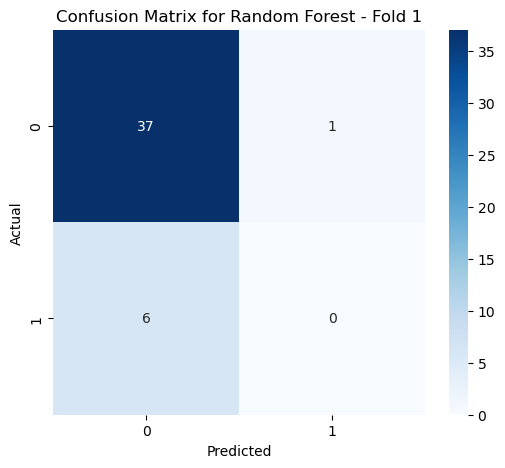

  Train Accuracy: 0.8778
  Validation Accuracy: 0.8605
  Test Accuracy: 0.8409
  Train F-beta Score: 0.5417
  Validation F-beta Score: 0.0000
  Test F-beta Score: 0.0000
  Train F1 Score: 0.4211
  Validation F1 Score: 0.0000
  Test F1 Score: 0.0000
  Train Recall: 1.0000
  Validation Recall: 0.0000
  Test Recall: 0.0000
  Train Precision: 0.2667
  Validation Precision: 0.0000
  Test Precision: 0.0000
  Train PR AUC: 0.6333
  Validation PR AUC: 0.5000
  Test PR AUC: 0.0682

Fold 2:
  Training set: X shape = (177, 16), Y shape = (177,), Size = 177
  Validation set:  X shape = (43, 16), Y shape = (43,), Size = 43
  Testing set:  X shape = (44, 16), Y shape = (44,), Size = 44

Fold 2 - Class Distribution in Test Set:
  Total samples: 44
  Class Counts:
wildfire_frequency
0    36
1     8
Name: count, dtype: int64
  Majority Class: 0
  Majority Class Count: 36

Baseline Metric Calculations:
  Accuracy: 0.18181818181818182
  Precision: 0.18181818181818182
  Recall: 1
  F1 Score: 0.30769230769

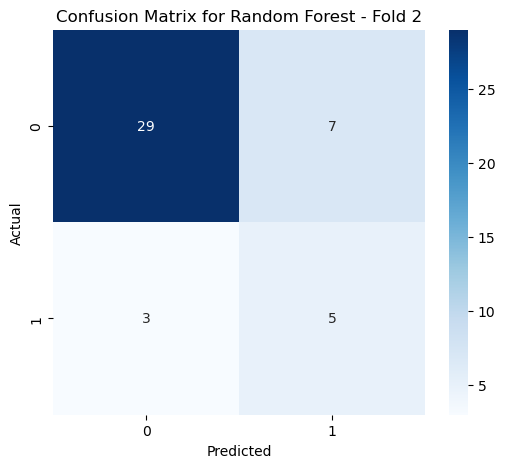

  Train Accuracy: 0.8362
  Validation Accuracy: 0.8372
  Test Accuracy: 0.7727
  Train F-beta Score: 0.4522
  Validation F-beta Score: 0.5508
  Test F-beta Score: 0.5417
  Train F1 Score: 0.3556
  Validation F1 Score: 0.5882
  Test F1 Score: 0.5000
  Train Recall: 0.8000
  Validation Recall: 0.5000
  Test Recall: 0.6250
  Train Precision: 0.2286
  Validation Precision: 0.7143
  Test Precision: 0.4167
  Train PR AUC: 0.5199
  Validation PR AUC: 0.6653
  Test PR AUC: 0.5549

Fold 3:
  Training set: X shape = (264, 16), Y shape = (264,), Size = 264
  Validation set:  X shape = (43, 16), Y shape = (43,), Size = 43
  Testing set:  X shape = (44, 16), Y shape = (44,), Size = 44

Fold 3 - Class Distribution in Test Set:
  Total samples: 44
  Class Counts:
wildfire_frequency
0    31
1    13
Name: count, dtype: int64
  Majority Class: 0
  Majority Class Count: 31

Baseline Metric Calculations:
  Accuracy: 0.29545454545454547
  Precision: 0.29545454545454547
  Recall: 1
  F1 Score: 0.45614035087

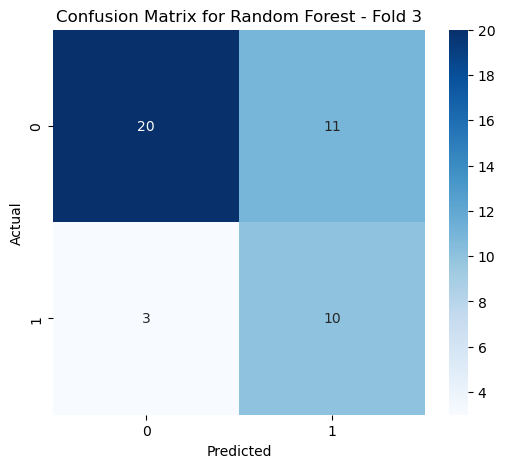

  Train Accuracy: 0.6970
  Validation Accuracy: 0.7209
  Test Accuracy: 0.6818
  Train F-beta Score: 0.4924
  Validation F-beta Score: 0.6842
  Test F-beta Score: 0.6468
  Train F1 Score: 0.3846
  Validation F1 Score: 0.5714
  Test F1 Score: 0.5882
  Train Recall: 0.8929
  Validation Recall: 1.0000
  Test Recall: 0.7692
  Train Precision: 0.2451
  Validation Precision: 0.4000
  Test Precision: 0.4762
  Train PR AUC: 0.5747
  Validation PR AUC: 0.7000
  Test PR AUC: 0.6568

Fold 4:
  Training set: X shape = (351, 16), Y shape = (351,), Size = 351
  Validation set:  X shape = (43, 16), Y shape = (43,), Size = 43
  Testing set:  X shape = (44, 16), Y shape = (44,), Size = 44

Fold 4 - Class Distribution in Test Set:
  Total samples: 44
  Class Counts:
wildfire_frequency
0    33
1    11
Name: count, dtype: int64
  Majority Class: 0
  Majority Class Count: 33

Baseline Metric Calculations:
  Accuracy: 0.25
  Precision: 0.25
  Recall: 1
  F1 Score: 0.4
  F1.5 Score: 0.52
  ROC AUC: 0.5
  PR 

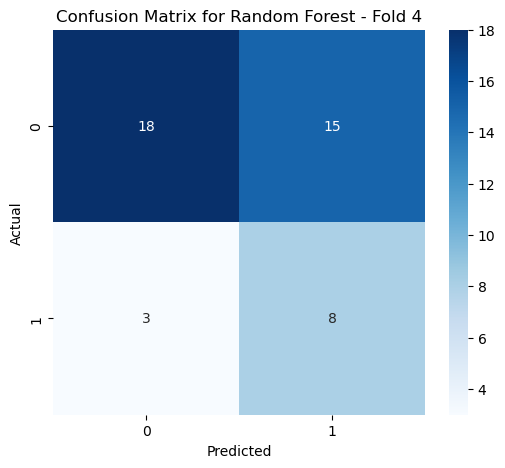

  Train Accuracy: 0.6638
  Validation Accuracy: 0.6977
  Test Accuracy: 0.5909
  Train F-beta Score: 0.5351
  Validation F-beta Score: 0.6599
  Test F-beta Score: 0.5445
  Train F1 Score: 0.4272
  Validation F1 Score: 0.6061
  Test F1 Score: 0.4706
  Train Recall: 0.8980
  Validation Recall: 0.7692
  Test Recall: 0.7273
  Train Precision: 0.2803
  Validation Precision: 0.5000
  Test Precision: 0.3478
  Train PR AUC: 0.5962
  Validation PR AUC: 0.6695
  Test PR AUC: 0.5716

Fold 5:
  Training set: X shape = (438, 16), Y shape = (438,), Size = 438
  Validation set:  X shape = (43, 16), Y shape = (43,), Size = 43
  Testing set:  X shape = (44, 16), Y shape = (44,), Size = 44

Fold 5 - Class Distribution in Test Set:
  Total samples: 44
  Class Counts:
wildfire_frequency
0    28
1    16
Name: count, dtype: int64
  Majority Class: 0
  Majority Class Count: 28

Baseline Metric Calculations:
  Accuracy: 0.36363636363636365
  Precision: 0.36363636363636365
  Recall: 1
  F1 Score: 0.53333333333

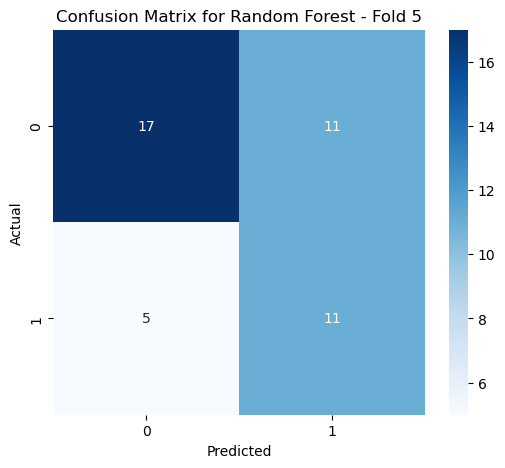

  Train Accuracy: 0.6712
  Validation Accuracy: 0.6977
  Test Accuracy: 0.6364
  Train F-beta Score: 0.5609
  Validation F-beta Score: 0.5759
  Test F-beta Score: 0.6164
  Train F1 Score: 0.4627
  Validation F1 Score: 0.5185
  Test F1 Score: 0.5789
  Train Recall: 0.8493
  Validation Recall: 0.7000
  Test Recall: 0.6875
  Train Precision: 0.3179
  Validation Precision: 0.4118
  Test Precision: 0.5000
  Train PR AUC: 0.5962
  Validation PR AUC: 0.5908
  Test PR AUC: 0.6506

Overall Metrics:
Accuracy - Train: Mean = 0.7492, Std Dev = 0.1002
Accuracy - Validation: Mean = 0.7628, Std Dev = 0.0795
Accuracy - Test: Mean = 0.7045, Std Dev = 0.1016
F-beta Score - Train: Mean = 0.5164, Std Dev = 0.0438
F-beta Score - Validation: Mean = 0.4942, Std Dev = 0.2818
F-beta Score - Test: Mean = 0.4699, Std Dev = 0.2666
F1 Score - Train: Mean = 0.4102, Std Dev = 0.0412
F1 Score - Validation: Mean = 0.4568, Std Dev = 0.2575
F1 Score - Test: Mean = 0.4276, Std Dev = 0.2443
Recall - Train: Mean = 0.8880, 

In [46]:
# random forest classifier with validation

f1_scorer = make_scorer(recall_score)

# param_grid
param_grid = {
    'model__n_estimators': [100],
    'model__max_depth': [1, 2, 3, 10, 30, 100],
    'model__max_features': [0.25, 0.5, 0.75, 1.0]
}

metrics = {
    "Accuracy": accuracy_score,
    "F-beta Score": lambda y_true, y_pred: fbeta_score(y_true, y_pred, beta=1.5),
    "F1 Score": f1_score,
    "Recall": recall_score,
    "Precision": precision_score,
 #   "ROC AUC": roc_auc_score,
    "PR AUC": lambda y_true, y_pred: compute_pr_auc(y_true, y_pred)
}

tscv = TimeSeriesSplit(n_splits=5)

best_models_forest = []

class_distributions = {}
forest_baseline_metrics = {}
forest_means = {}
forest_stds = {}

# function to consistently format metric names
def format_metric_name(metric_name):
    return re.sub(r'[^a-zA-Z0-9]+', '_', metric_name.lower())
    
# initialise scores dictionaries
scores_per_fold = {f"train_{format_metric_name(name)}": [] for name in metrics}
scores_per_fold.update({f"test_{format_metric_name(name)}": [] for name in metrics})
scores_per_fold.update({f"val_{format_metric_name(name)}": [] for name in metrics})  # Add validation scores

# data splitting, model training, & evaluation
for fold_idx, (train_index, test_index) in enumerate(tscv.split(X), start=1):
    # Split data into train and test sets
    X_train = X.iloc[train_index]
    Y_train = Y.iloc[train_index]
    X_test_full = X.iloc[test_index]
    Y_test_full = Y.iloc[test_index]

    # split the test set into 10% validation and 10% test (chronologically)
    split_point = len(X_test_full) // 2
    X_val = X_test_full.iloc[:split_point]
    Y_val = Y_test_full.iloc[:split_point]
    
    X_test = X_test_full.iloc[split_point:]
    Y_test = Y_test_full.iloc[split_point:]

    print(f"\nFold {fold_idx}:")
    print(f"  Training set: X shape = {X_train.shape}, Y shape = {Y_train.shape}, Size = {X_train.shape[0]}")
    print(f"  Validation set:  X shape = {X_val.shape}, Y shape = {Y_val.shape}, Size = {X_val.shape[0]}")
    print(f"  Testing set:  X shape = {X_test.shape}, Y shape = {Y_test.shape}, Size = {X_test.shape[0]}")

    # count class occurrences in Y_test
    class_counts = Y_test.value_counts()
    total = len(Y_test)
    majority_class = class_counts.idxmax()
    majority_class_count = class_counts.max()
    num_class_1 = class_counts.get(1, 0)
    num_class_0 = class_counts.get(0, 0)
    baseline_probs = [1 if majority_class == 1 else 0] * len(Y_test)
    precision_baseline, recall_baseline, _ = precision_recall_curve(Y_test, baseline_probs)

    # debugging prints for class distribution
    print(f"\nFold {fold_idx} - Class Distribution in Test Set:")
    print(f"  Total samples: {total}")
    print(f"  Class Counts:\n{class_counts}")
    print(f"  Majority Class: {majority_class}")
    print(f"  Majority Class Count: {majority_class_count}")
    
    # store class distribution
    class_distributions[fold_idx] = {
        "Class 0": num_class_0,
        "Class 1": num_class_1
    }

    # baseline metrics: predicting all points as class 1
    accuracy = num_class_1 / (num_class_1 + num_class_0)
    precision = num_class_1 / (num_class_1 + num_class_0)
    recall = 1
    f1 = (2*precision*recall) / (precision+recall)
    f1_5 = (3.25*precision*recall) / ((2.25*precision) + recall)
    roc_auc = 0.5
    pr_auc = num_class_1 / (num_class_1 + num_class_0)

    print("\nBaseline Metric Calculations:")
    print(f"  Accuracy: {accuracy}")
    print(f"  Precision: {precision}")
    print(f"  Recall: {recall}")
    print(f"  F1 Score: {f1}")
    print(f"  F1.5 Score: {f1_5}")
    print(f"  ROC AUC: {roc_auc}")
    print(f"  PR AUC: {pr_auc}")
    
    forest_baseline_metrics[fold_idx] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "F1.5": f1_5,
        "ROC AUC": roc_auc,
        "PR AUC": pr_auc
    }
    
    # pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  
        ('model', RandomForestClassifier(class_weight='balanced', random_state=1))
    ])
    
    # GridSearchCV with tscv
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=tscv,
        scoring=f1_scorer,
        refit=True,  # refit best model on the full training data
        n_jobs=-1,  
        verbose=1
    )
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        grid_search.fit(X_train, Y_train)
    
    # use the validation set to select the best model
    best_model_idx = np.argmax([grid_search.score(X_val, Y_val) for model in grid_search.cv_results_['params']])

    # find best parameters using X_train
    best_params = grid_search.best_params_
    best_model_forest = grid_search.best_estimator_
    print(f"Fold {fold_idx} -> Best Params: {best_params}")

    # evaluate the best model on the validation set (X_val, Y_val)
    y_val_pred_probs = best_model_forest.predict_proba(X_val)[:, 1]
    y_val_pred = best_model_forest.predict(X_val)

    #evalualte on X_train 
    y_train_pred = best_model_forest.predict(X_train)

    # evaluate on X_test
    y_test_pred_probs = best_model_forest.predict_proba(X_test)[:, 1]
    y_test_pred = best_model_forest.predict(X_test)

    # predict probabilities (needed for PR AUC calculation)
    y_pred_probs = best_model_forest.predict_proba(X_test)[:, 1]  # Get probabilities for class 1
    
    # calculate PR AUC for the test set
    pr_auc_value = compute_pr_auc(Y_test, y_pred_probs)

    #calculate confusion matrix for each fold
    cm = confusion_matrix(Y_test, y_test_pred, labels=[0, 1])
        
    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix for Random Forest - Fold {fold_idx}")
    plt.show()
    
    #for loop for calculating train & test metrics
    #print(f"Fold {fold_idx} metrics:")
    for name, func in metrics.items():
        formatted_name = format_metric_name(name)

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            # Train metrics
            train_score = func(Y_train, y_train_pred)
            print(f"  Train {name}: {train_score:.4f}")
            scores_per_fold[f"train_{formatted_name}"].append(train_score)
    
            # Validation metrics
            val_score = func(Y_val, y_val_pred)
            print(f"  Validation {name}: {val_score:.4f}")
            scores_per_fold[f"val_{formatted_name}"].append(val_score)
            
            if np.any(Y_test == 1):  # Check if positive class exists
                precision, recall, thresholds = precision_recall_curve(Y_test, y_test_pred)
            else:
                print("Warning: No positive class in y_true. Skipping curve computation.")
            
            # Test metrics
            test_score = func(Y_test, y_test_pred)
            print(f"  Test {name}: {test_score:.4f}")
            scores_per_fold[f"test_{formatted_name}"].append(test_score)
            
# calculate and save mean and std metrics
print("\nOverall Metrics:")
for metric_name in metrics:
    formatted_name = format_metric_name(metric_name)
    train_key = f"train_{formatted_name}"
    val_key = f"val_{formatted_name}"
    test_key = f"test_{formatted_name}"
    
    avg_train = np.mean(scores_per_fold[train_key])
    std_train = np.std(scores_per_fold[train_key], ddof=1)
    avg_val = np.mean(scores_per_fold[val_key])
    std_val = np.std(scores_per_fold[val_key], ddof=1)
    avg_test = np.mean(scores_per_fold[test_key])
    std_test = np.std(scores_per_fold[test_key], ddof=1)

    # save to dictionaries for model comparison
    forest_means[f"forest_{formatted_name}_mean"] = {
        "train": avg_train,
        "val": avg_val,
        "test": avg_test
    }
    forest_stds[f"forest_{formatted_name}_std"] = {
        "train": std_train,
        "val": std_val,
        "test": std_test
    }
        
    print(f"{metric_name} - Train: Mean = {avg_train:.4f}, Std Dev = {std_train:.4f}")
    print(f"{metric_name} - Validation: Mean = {avg_val:.4f}, Std Dev = {std_val:.4f}")
    print(f"{metric_name} - Test: Mean = {avg_test:.4f}, Std Dev = {std_test:.4f}")

#print baselines at the end for each fold:
print("\nBaseline Metrics per Fold:")
for fold, metrics in forest_baseline_metrics.items():
    print(f"Fold {fold}: {metrics}")

#### SVC


Fold 1:
  Training set: X shape = (90, 16), Y shape = (90,), Size = 90
  Validation set:  X shape = (43, 16), Y shape = (43,), Size = 43
  Testing set:  X shape = (44, 16), Y shape = (44,), Size = 44

Fold 1 - Class Distribution in Test Set:
  Total samples: 44
  Class Counts:
wildfire_frequency
0    38
1     6
Name: count, dtype: int64
  Majority Class: 0
  Majority Class Count: 38

Baseline Metric Calculations:
  Accuracy: 0.13636363636363635
  Precision: 0.13636363636363635
  Recall: 1
  F1 Score: 0.24000000000000002
  F1.5 Score: 0.3391304347826087
  ROC AUC: 0.5
  PR AUC: 0.13636363636363635
Fitting 5 folds for each of 63 candidates, totalling 315 fits
Fold 1 -> Best Params: {'model__C': 10, 'model__gamma': 0.0005}


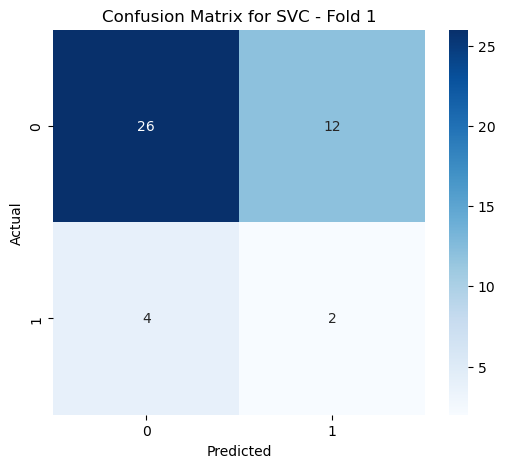

  Train Accuracy: 0.8000
  Validation Accuracy: 0.7674
  Test Accuracy: 0.6364
  Train F-beta Score: 0.4194
  Validation F-beta Score: 0.0000
  Test F-beta Score: 0.2364
  Train F1 Score: 0.3077
  Validation F1 Score: 0.0000
  Test F1 Score: 0.2000
  Train Recall: 1.0000
  Validation Recall: 0.0000
  Test Recall: 0.3333
  Train Precision: 0.1818
  Validation Precision: 0.0000
  Test Precision: 0.1429
  Train PR AUC: 0.5909
  Validation PR AUC: 0.5000
  Test PR AUC: 0.2835

Fold 2:
  Training set: X shape = (177, 16), Y shape = (177,), Size = 177
  Validation set:  X shape = (43, 16), Y shape = (43,), Size = 43
  Testing set:  X shape = (44, 16), Y shape = (44,), Size = 44

Fold 2 - Class Distribution in Test Set:
  Total samples: 44
  Class Counts:
wildfire_frequency
0    36
1     8
Name: count, dtype: int64
  Majority Class: 0
  Majority Class Count: 36

Baseline Metric Calculations:
  Accuracy: 0.18181818181818182
  Precision: 0.18181818181818182
  Recall: 1
  F1 Score: 0.30769230769

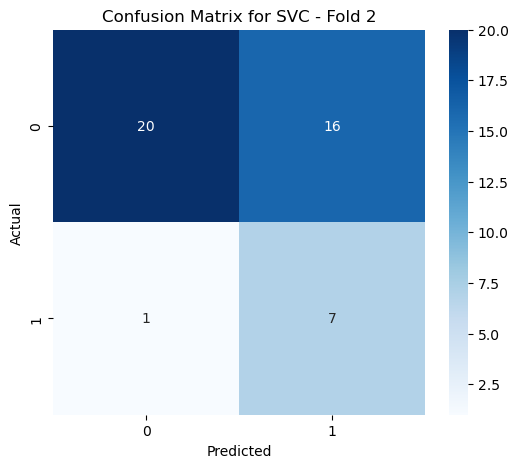

  Train Accuracy: 0.7514
  Validation Accuracy: 0.7674
  Test Accuracy: 0.6136
  Train F-beta Score: 0.3926
  Validation F-beta Score: 0.7222
  Test F-beta Score: 0.5549
  Train F1 Score: 0.2903
  Validation F1 Score: 0.6429
  Test F1 Score: 0.4516
  Train Recall: 0.9000
  Validation Recall: 0.9000
  Test Recall: 0.8750
  Train Precision: 0.1731
  Validation Precision: 0.5000
  Test Precision: 0.3043
  Train PR AUC: 0.5394
  Validation PR AUC: 0.7116
  Test PR AUC: 0.6010

Fold 3:
  Training set: X shape = (264, 16), Y shape = (264,), Size = 264
  Validation set:  X shape = (43, 16), Y shape = (43,), Size = 43
  Testing set:  X shape = (44, 16), Y shape = (44,), Size = 44

Fold 3 - Class Distribution in Test Set:
  Total samples: 44
  Class Counts:
wildfire_frequency
0    31
1    13
Name: count, dtype: int64
  Majority Class: 0
  Majority Class Count: 31

Baseline Metric Calculations:
  Accuracy: 0.29545454545454547
  Precision: 0.29545454545454547
  Recall: 1
  F1 Score: 0.45614035087

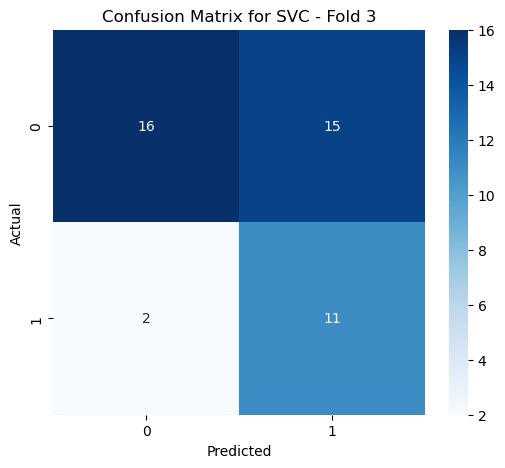

  Train Accuracy: 0.7727
  Validation Accuracy: 0.6744
  Test Accuracy: 0.6136
  Train F-beta Score: 0.5455
  Validation F-beta Score: 0.6500
  Test F-beta Score: 0.6471
  Train F1 Score: 0.4444
  Validation F1 Score: 0.5333
  Test F1 Score: 0.5641
  Train Recall: 0.8571
  Validation Recall: 1.0000
  Test Recall: 0.8462
  Train Precision: 0.3000
  Validation Precision: 0.3636
  Test Precision: 0.4231
  Train PR AUC: 0.5861
  Validation PR AUC: 0.6818
  Test PR AUC: 0.6573

Fold 4:
  Training set: X shape = (351, 16), Y shape = (351,), Size = 351
  Validation set:  X shape = (43, 16), Y shape = (43,), Size = 43
  Testing set:  X shape = (44, 16), Y shape = (44,), Size = 44

Fold 4 - Class Distribution in Test Set:
  Total samples: 44
  Class Counts:
wildfire_frequency
0    33
1    11
Name: count, dtype: int64
  Majority Class: 0
  Majority Class Count: 33

Baseline Metric Calculations:
  Accuracy: 0.25
  Precision: 0.25
  Recall: 1
  F1 Score: 0.4
  F1.5 Score: 0.52
  ROC AUC: 0.5
  PR 

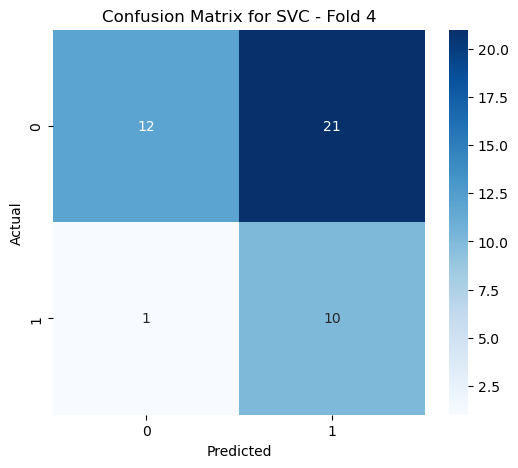

  Train Accuracy: 0.7721
  Validation Accuracy: 0.6512
  Test Accuracy: 0.5000
  Train F-beta Score: 0.6060
  Validation F-beta Score: 0.6714
  Test F-beta Score: 0.5830
  Train F1 Score: 0.5122
  Validation F1 Score: 0.5946
  Test F1 Score: 0.4762
  Train Recall: 0.8571
  Validation Recall: 0.8462
  Test Recall: 0.9091
  Train Precision: 0.3652
  Validation Precision: 0.4583
  Test Precision: 0.3226
  Train PR AUC: 0.6212
  Validation PR AUC: 0.6755
  Test PR AUC: 0.6272

Fold 5:
  Training set: X shape = (438, 16), Y shape = (438,), Size = 438
  Validation set:  X shape = (43, 16), Y shape = (43,), Size = 43
  Testing set:  X shape = (44, 16), Y shape = (44,), Size = 44

Fold 5 - Class Distribution in Test Set:
  Total samples: 44
  Class Counts:
wildfire_frequency
0    28
1    16
Name: count, dtype: int64
  Majority Class: 0
  Majority Class Count: 28

Baseline Metric Calculations:
  Accuracy: 0.36363636363636365
  Precision: 0.36363636363636365
  Recall: 1
  F1 Score: 0.53333333333

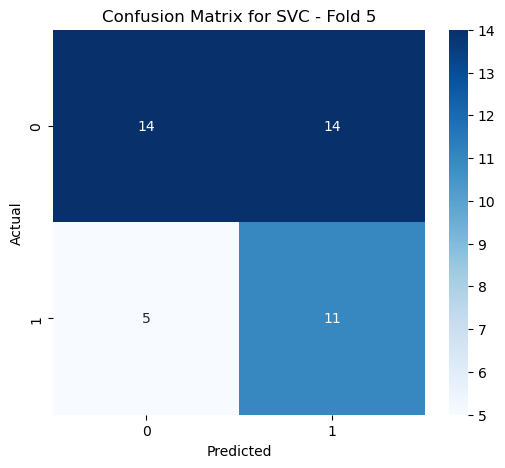

  Train Accuracy: 0.6370
  Validation Accuracy: 0.6279
  Test Accuracy: 0.5682
  Train F-beta Score: 0.5556
  Validation F-beta Score: 0.6290
  Test F-beta Score: 0.5861
  Train F1 Score: 0.4498
  Validation F1 Score: 0.5294
  Test F1 Score: 0.5366
  Train Recall: 0.8904
  Validation Recall: 0.9000
  Test Recall: 0.6875
  Train Precision: 0.3009
  Validation Precision: 0.3750
  Test Precision: 0.4400
  Train PR AUC: 0.6048
  Validation PR AUC: 0.6491
  Test PR AUC: 0.6206

Overall Metrics:
Accuracy - Train: Mean = 0.7466, Std Dev = 0.0637
Accuracy - Validation: Mean = 0.6977, Std Dev = 0.0658
Accuracy - Test: Mean = 0.5864, Std Dev = 0.0543
F-beta Score - Train: Mean = 0.5038, Std Dev = 0.0927
F-beta Score - Validation: Mean = 0.5345, Std Dev = 0.3008
F-beta Score - Test: Mean = 0.5215, Std Dev = 0.1629
F1 Score - Train: Mean = 0.4009, Std Dev = 0.0969
F1 Score - Validation: Mean = 0.4600, Std Dev = 0.2614
F1 Score - Test: Mean = 0.4457, Std Dev = 0.1446
Recall - Train: Mean = 0.9009, 

In [47]:
# svc with validation

scorer = make_scorer(f1_score)

# param_grid
param_grid = {
    'model__gamma': [0.00001, 0.0005, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'model__C': [100, 10, 1, 0.1, 0.01, 0.001, 0.0001]
}

metrics = {
    "Accuracy": accuracy_score,
    "F-beta Score": lambda y_true, y_pred: fbeta_score(y_true, y_pred, beta=1.5),
    "F1 Score": f1_score,
    "Recall": recall_score,
    "Precision": precision_score,
 #   "ROC AUC": roc_auc_score,
    "PR AUC": lambda y_true, y_pred: compute_pr_auc(y_true, y_pred)
}

tscv = TimeSeriesSplit(n_splits=5)

best_models_svc = []

class_distributions = {}
svc_baseline_metrics = {}
svc_means = {}
svc_stds = {}

# consistently format metric names
def format_metric_name(metric_name):
    return re.sub(r'[^a-zA-Z0-9]+', '_', metric_name.lower())
    
# initialise scores dictionaries
scores_per_fold = {f"train_{format_metric_name(name)}": [] for name in metrics}
scores_per_fold.update({f"test_{format_metric_name(name)}": [] for name in metrics})
scores_per_fold.update({f"val_{format_metric_name(name)}": [] for name in metrics})  # Add validation scores

# data splitting, model training, & evaluation
for fold_idx, (train_index, test_index) in enumerate(tscv.split(X), start=1):
    # Split data into train and test sets
    X_train = X.iloc[train_index]
    Y_train = Y.iloc[train_index]
    X_test_full = X.iloc[test_index]
    Y_test_full = Y.iloc[test_index]

    # Split the test set into 10% validation and 10% test (chronologically)
    split_point = len(X_test_full) // 2
    X_val = X_test_full.iloc[:split_point]
    Y_val = Y_test_full.iloc[:split_point]
    
    X_test = X_test_full.iloc[split_point:]
    Y_test = Y_test_full.iloc[split_point:]

    print(f"\nFold {fold_idx}:")
    print(f"  Training set: X shape = {X_train.shape}, Y shape = {Y_train.shape}, Size = {X_train.shape[0]}")
    print(f"  Validation set:  X shape = {X_val.shape}, Y shape = {Y_val.shape}, Size = {X_val.shape[0]}")
    print(f"  Testing set:  X shape = {X_test.shape}, Y shape = {Y_test.shape}, Size = {X_test.shape[0]}")
    
    # count class occurrences in Y_test
    class_counts = Y_test.value_counts()
    total = len(Y_test)
    majority_class = class_counts.idxmax()
    majority_class_count = class_counts.max()
    num_class_1 = class_counts.get(1, 0)
    num_class_0 = class_counts.get(0, 0)
    baseline_probs = [1 if majority_class == 1 else 0] * len(Y_test)
    precision_baseline, recall_baseline, _ = precision_recall_curve(Y_test, baseline_probs)

    # debugging prints for class distribution
    print(f"\nFold {fold_idx} - Class Distribution in Test Set:")
    print(f"  Total samples: {total}")
    print(f"  Class Counts:\n{class_counts}")
    print(f"  Majority Class: {majority_class}")
    print(f"  Majority Class Count: {majority_class_count}")
    
    # store class distribution
    class_distributions[fold_idx] = {
        "Class 0": num_class_0,
        "Class 1": num_class_1
    }

    # baseline metrics: predicting all points as class 1
    accuracy = num_class_1 / (num_class_1 + num_class_0)
    precision = num_class_1 / (num_class_1 + num_class_0)
    recall = 1
    f1 = (2*precision*recall) / (precision+recall)
    f1_5 = (3.25*precision*recall) / ((2.25*precision) + recall)
    roc_auc = 0.5
    pr_auc = num_class_1 / (num_class_1 + num_class_0)

    print("\nBaseline Metric Calculations:")
    print(f"  Accuracy: {accuracy}")
    print(f"  Precision: {precision}")
    print(f"  Recall: {recall}")
    print(f"  F1 Score: {f1}")
    print(f"  F1.5 Score: {f1_5}")
    print(f"  ROC AUC: {roc_auc}")
    print(f"  PR AUC: {pr_auc}")
    
    svc_baseline_metrics[fold_idx] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "F1.5": f1_5,
        "ROC AUC": roc_auc,
        "PR AUC": pr_auc
    }
    
    # pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  
        ('model', SVC(class_weight='balanced', probability=True, random_state=1))
    ])
    
    # GridSearchCV with tscv
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=tscv,
        scoring=scorer,
        refit=True,  # refit best model on the full training data
        n_jobs=-1,  
        verbose=1
    )
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        grid_search.fit(X_train, Y_train)
    
    # use the validation set to select the best model
    best_model_idx = np.argmax([grid_search.score(X_val, Y_val) for model in grid_search.cv_results_['params']])

    # find best parameters using X_train
    best_params = grid_search.best_params_
    best_model_svc = grid_search.best_estimator_
    print(f"Fold {fold_idx} -> Best Params: {best_params}")

    # evalualte the best model on the validation set (X_val, Y_val)
    y_val_pred_probs = best_model_svc.predict_proba(X_val)[:, 1]
    y_val_pred = best_model_svc.predict(X_val)

    #evalualte on X_train 
    y_train_pred = best_model_svc.predict(X_train)

    # evalualte on X_test
    y_test_pred_probs = best_model_svc.predict_proba(X_test)[:, 1]
    y_test_pred = best_model_svc.predict(X_test)

    # predict probabilities (needed for PR AUC calculation)
    y_pred_probs = best_model_svc.predict_proba(X_test)[:, 1]  # Get probabilities for class 1
    
    # calculate PR AUC for the test set
    pr_auc_value = compute_pr_auc(Y_test, y_pred_probs)

    #calculate confusion matrix for each fold
    cm = confusion_matrix(Y_test, y_test_pred, labels=[0, 1])
        
    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix for SVC - Fold {fold_idx}")
    plt.show()
    
    #for loop for calculating train & test metrics
    #print(f"Fold {fold_idx} metrics:")
    for name, func in metrics.items():
        formatted_name = format_metric_name(name)

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            # Train metrics
            train_score = func(Y_train, y_train_pred)
            print(f"  Train {name}: {train_score:.4f}")
            scores_per_fold[f"train_{formatted_name}"].append(train_score)
    
            # Validation metrics
            val_score = func(Y_val, y_val_pred)
            print(f"  Validation {name}: {val_score:.4f}")
            scores_per_fold[f"val_{formatted_name}"].append(val_score)
            
            # Test metrics
            test_score = func(Y_test, y_test_pred)
            print(f"  Test {name}: {test_score:.4f}")
            scores_per_fold[f"test_{formatted_name}"].append(test_score)

# calculate and save mean and std metrics
print("\nOverall Metrics:")
for metric_name in metrics:
    formatted_name = format_metric_name(metric_name)
    train_key = f"train_{formatted_name}"
    val_key = f"val_{formatted_name}"
    test_key = f"test_{formatted_name}"
    
    avg_train = np.mean(scores_per_fold[train_key])
    std_train = np.std(scores_per_fold[train_key], ddof=1)
    avg_val = np.mean(scores_per_fold[val_key])
    std_val = np.std(scores_per_fold[val_key], ddof=1)
    avg_test = np.mean(scores_per_fold[test_key])
    std_test = np.std(scores_per_fold[test_key], ddof=1)

    # save to dictionaries for model comparison
    svc_means[f"svc_{formatted_name}_mean"] = {
        "train": avg_train,
        "val": avg_val,
        "test": avg_test
    }
    svc_stds[f"svc_{formatted_name}_std"] = {
        "train": std_train,
        "val": std_val,
        "test": std_test
    }
        
    print(f"{metric_name} - Train: Mean = {avg_train:.4f}, Std Dev = {std_train:.4f}")
    print(f"{metric_name} - Validation: Mean = {avg_val:.4f}, Std Dev = {std_val:.4f}")
    print(f"{metric_name} - Test: Mean = {avg_test:.4f}, Std Dev = {std_test:.4f}")

#print baselines at the end for each fold:
print("\nBaseline Metrics per Fold:")
for fold, metrics in svc_baseline_metrics.items():
    print(f"Fold {fold}: {metrics}")

#### Model Comparison

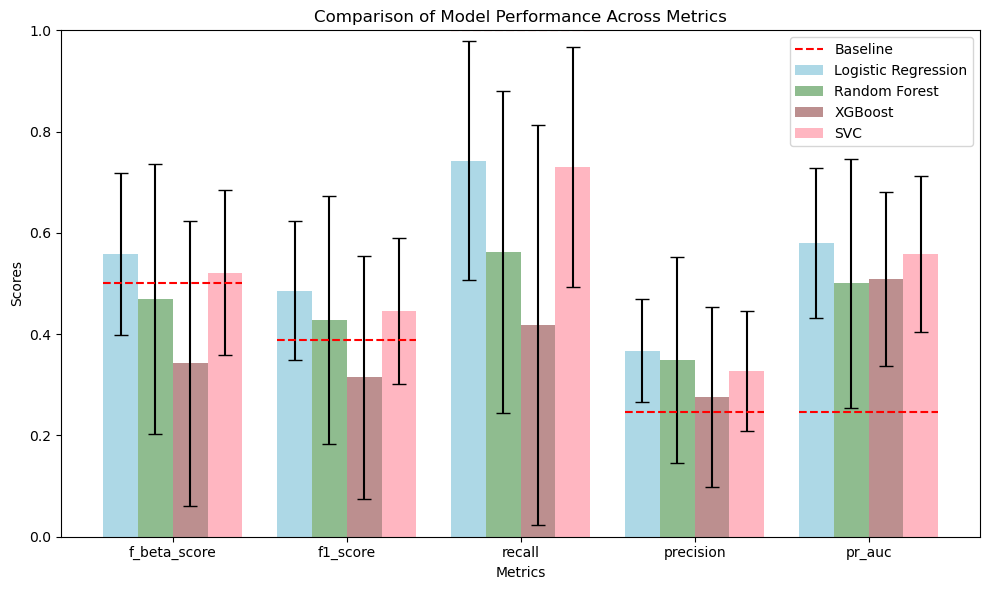

In [48]:
# define metrics and models
metrics = ['f_beta_score', 'f1_score', 'recall', 'precision', 'pr_auc']
models = ['logistic_regression', 'forest', 'xgb', 'svc']

# lists to store means and stds for each model and metric
means = []
stds = []

baselines = [0.5011, 0.3874, 1.0, 0.2455, 0.2455]

# iterate over each model and metric
for model in models:
    model_means = []
    model_stds = []
    for metric in metrics:
        # construct keys dynamically to fetch the means and stds from the pre-defined dictionaries
        mean_key = f"{model}_{metric}_mean"
        std_key = f"{model}_{metric}_std"
        
        # check if key exists
        try:
            model_means.append(eval(f"{model}_means")[mean_key]['test'])
            model_stds.append(eval(f"{model}_stds")[std_key]['test'])
        except KeyError as e:
            print(f"KeyError: {e}. Could not find the key {mean_key} or {std_key}.")
            model_means.append(np.nan)
            model_stds.append(np.nan)
    
    # append model's means and stds to the lists
    means.append(model_means)
    stds.append(model_stds)

# convert lists to numpy arrays for easier plotting
means = np.array(means)
stds = np.array(stds)

# define positions of the bars
x = np.arange(len(metrics))
width = 0.2

fig, ax = plt.subplots(figsize=(10, 6))

# plot bars for each model
bars_logistic = ax.bar(x - 1.5 * width, means[0], width, yerr=stds[0], label='Logistic Regression', color='lightblue', capsize=5)
bars_forest = ax.bar(x - 0.5 * width, means[1], width, yerr=stds[1], label='Random Forest', color='darkseagreen', capsize=5)
bars_xgb = ax.bar(x + 0.5 * width, means[2], width, yerr=stds[2], label='XGBoost', color='rosybrown', capsize=5)
bars_svc = ax.bar(x + 1.5 * width, means[3], width, yerr=stds[3], label='SVC', color='lightpink', capsize=5)

for i, baseline in enumerate(baselines):
    ax.hlines(y=baseline, xmin=x[i] - 2 * width, xmax=x[i] + 2 * width, colors='red', linestyles='dashed', label=None if i > 0 else 'Baseline')

# add labels, title, and custom x-axis tick labels
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Model Performance Across Metrics')
ax.set_xticks(x)
ax.set_ylim(0, 1)
ax.set_xticklabels(metrics)
ax.legend()

plt.savefig('ML_mean_std_metrics.png', dpi=300)

plt.tight_layout()
plt.show()


#### Best Model Interpretation 


Fold 1:
  Training set: X shape = (90, 16), Y shape = (90,), Size = 90
  Validation set:  X shape = (43, 16), Y shape = (43,), Size = 43
  Testing set:  X shape = (44, 16), Y shape = (44,), Size = 44

Fold 1 - Class Distribution in Test Set:
  Total samples: 44
  Class Counts:
wildfire_frequency
0    38
1     6
Name: count, dtype: int64
  Majority Class: 0
  Majority Class Count: 38

Baseline Metric Calculations:
  Accuracy: 0.13636363636363635
  Precision: 0.13636363636363635
  Recall: 1
  F1 Score: 0.24000000000000002
  F1.5 Score: 0.3391304347826087
  PR AUC: 0.13636363636363635
Fitting 5 folds for each of 168 candidates, totalling 840 fits
year                     int32
month                    int32
tmax_degC              float64
airfrost_days            int64
totalrain_mm           float64
totalsun_hours         float64
tmax_degC_lag_1        float64
tmax_degC_lag_6        float64
tmax_degC_lag_12       float64
totalrain_mm_lag_1     float64
totalrain_mm_lag_6     float64
totalr

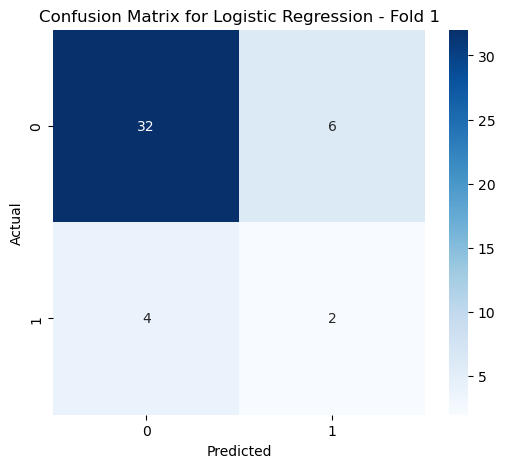

  Train Accuracy: 0.8667
  Validation Accuracy: 0.8837
  Test Accuracy: 0.7727
  Train F-beta Score: 0.5200
  Validation F-beta Score: 0.0000
  Test F-beta Score: 0.3023
  Train F1 Score: 0.4000
  Validation F1 Score: 0.0000
  Test F1 Score: 0.2857
  Train Recall: 1.0000
  Validation Recall: 0.0000
  Test Recall: 0.3333
  Train Precision: 0.2500
  Validation Precision: 0.0000
  Test Precision: 0.2500
  Train PR AUC: 0.6250
  Validation PR AUC: 0.5000
  Test PR AUC: 0.3371

Fold 2:
  Training set: X shape = (177, 16), Y shape = (177,), Size = 177
  Validation set:  X shape = (43, 16), Y shape = (43,), Size = 43
  Testing set:  X shape = (44, 16), Y shape = (44,), Size = 44

Fold 2 - Class Distribution in Test Set:
  Total samples: 44
  Class Counts:
wildfire_frequency
0    36
1     8
Name: count, dtype: int64
  Majority Class: 0
  Majority Class Count: 36

Baseline Metric Calculations:
  Accuracy: 0.18181818181818182
  Precision: 0.18181818181818182
  Recall: 1
  F1 Score: 0.30769230769

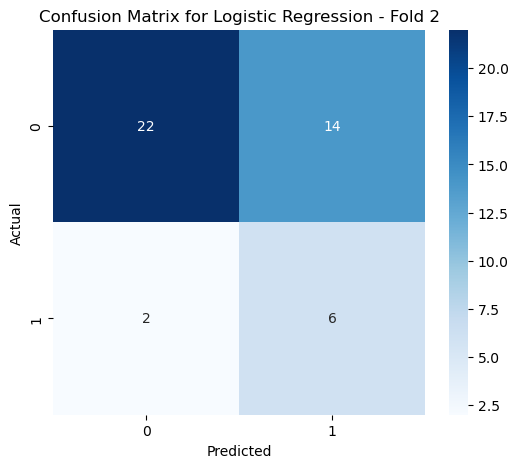

  Train Accuracy: 0.8192
  Validation Accuracy: 0.8140
  Test Accuracy: 0.6364
  Train F-beta Score: 0.4680
  Validation F-beta Score: 0.7597
  Test F-beta Score: 0.5132
  Train F1 Score: 0.3600
  Validation F1 Score: 0.6923
  Test F1 Score: 0.4286
  Train Recall: 0.9000
  Validation Recall: 0.9000
  Test Recall: 0.7500
  Train Precision: 0.2250
  Validation Precision: 0.5625
  Test Precision: 0.3000
  Train PR AUC: 0.5653
  Validation PR AUC: 0.7429
  Test PR AUC: 0.5477

Fold 3:
  Training set: X shape = (264, 16), Y shape = (264,), Size = 264
  Validation set:  X shape = (43, 16), Y shape = (43,), Size = 43
  Testing set:  X shape = (44, 16), Y shape = (44,), Size = 44

Fold 3 - Class Distribution in Test Set:
  Total samples: 44
  Class Counts:
wildfire_frequency
0    31
1    13
Name: count, dtype: int64
  Majority Class: 0
  Majority Class Count: 31

Baseline Metric Calculations:
  Accuracy: 0.29545454545454547
  Precision: 0.29545454545454547
  Recall: 1
  F1 Score: 0.45614035087

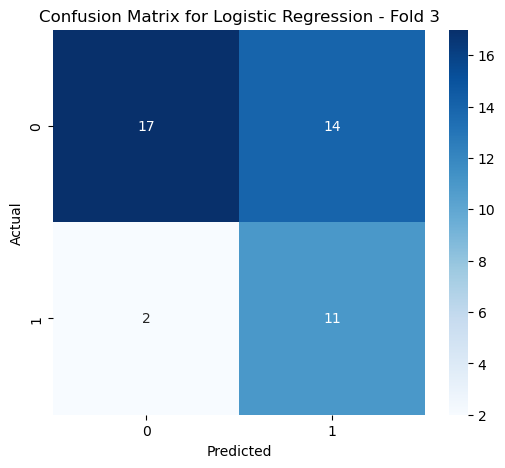

  Train Accuracy: 0.7462
  Validation Accuracy: 0.6512
  Test Accuracy: 0.6364
  Train F-beta Score: 0.5345
  Validation F-beta Score: 0.6341
  Test F-beta Score: 0.6590
  Train F1 Score: 0.4274
  Validation F1 Score: 0.5161
  Test F1 Score: 0.5789
  Train Recall: 0.8929
  Validation Recall: 1.0000
  Test Recall: 0.8462
  Train Precision: 0.2809
  Validation Precision: 0.3478
  Test Precision: 0.4400
  Train PR AUC: 0.5926
  Validation PR AUC: 0.6739
  Test PR AUC: 0.6658

Fold 4:
  Training set: X shape = (351, 16), Y shape = (351,), Size = 351
  Validation set:  X shape = (43, 16), Y shape = (43,), Size = 43
  Testing set:  X shape = (44, 16), Y shape = (44,), Size = 44

Fold 4 - Class Distribution in Test Set:
  Total samples: 44
  Class Counts:
wildfire_frequency
0    33
1    11
Name: count, dtype: int64
  Majority Class: 0
  Majority Class Count: 33

Baseline Metric Calculations:
  Accuracy: 0.25
  Precision: 0.25
  Recall: 1
  F1 Score: 0.4
  F1.5 Score: 0.52
  PR AUC: 0.25
Fitti

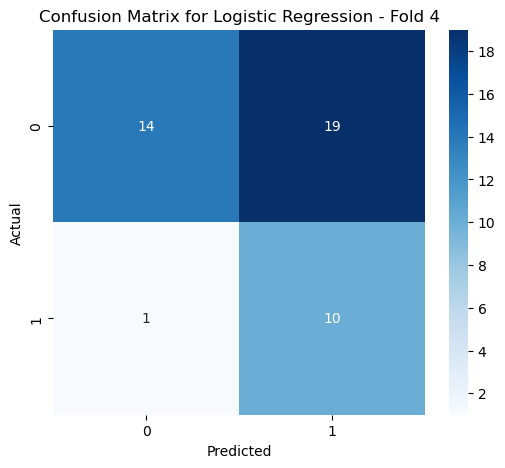

  Train Accuracy: 0.7521
  Validation Accuracy: 0.6512
  Test Accuracy: 0.5455
  Train F-beta Score: 0.5877
  Validation F-beta Score: 0.6714
  Test F-beta Score: 0.6047
  Train F1 Score: 0.4912
  Validation F1 Score: 0.5946
  Test F1 Score: 0.5000
  Train Recall: 0.8571
  Validation Recall: 0.8462
  Test Recall: 0.9091
  Train Precision: 0.3443
  Validation Precision: 0.4583
  Test Precision: 0.3448
  Train PR AUC: 0.6107
  Validation PR AUC: 0.6755
  Test PR AUC: 0.6383

Fold 5:
  Training set: X shape = (438, 16), Y shape = (438,), Size = 438
  Validation set:  X shape = (43, 16), Y shape = (43,), Size = 43
  Testing set:  X shape = (44, 16), Y shape = (44,), Size = 44

Fold 5 - Class Distribution in Test Set:
  Total samples: 44
  Class Counts:
wildfire_frequency
0    28
1    16
Name: count, dtype: int64
  Majority Class: 0
  Majority Class Count: 28

Baseline Metric Calculations:
  Accuracy: 0.36363636363636365
  Precision: 0.36363636363636365
  Recall: 1
  F1 Score: 0.53333333333

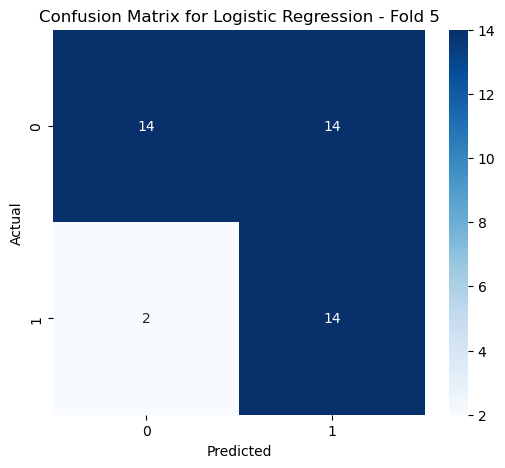

  Train Accuracy: 0.7443
  Validation Accuracy: 0.5814
  Test Accuracy: 0.6364
  Train F-beta Score: 0.5969
  Validation F-beta Score: 0.6436
  Test F-beta Score: 0.7109
  Train F1 Score: 0.5130
  Validation F1 Score: 0.5263
  Test F1 Score: 0.6364
  Train Recall: 0.8082
  Validation Recall: 1.0000
  Test Recall: 0.8750
  Train Precision: 0.3758
  Validation Precision: 0.3571
  Test Precision: 0.5000
  Train PR AUC: 0.6080
  Validation PR AUC: 0.6786
  Test PR AUC: 0.7102

Overall Metrics:
Accuracy - Train: Mean = 0.7857, Std Dev = 0.0550
Accuracy - Validation: Mean = 0.7163, Std Dev = 0.1267
Accuracy - Test: Mean = 0.6455, Std Dev = 0.0813
F-beta Score - Train: Mean = 0.5414, Std Dev = 0.0527
F-beta Score - Validation: Mean = 0.5418, Std Dev = 0.3069
F-beta Score - Test: Mean = 0.5580, Std Dev = 0.1606
F1 Score - Train: Mean = 0.4383, Std Dev = 0.0635
F1 Score - Validation: Mean = 0.4659, Std Dev = 0.2697
F1 Score - Test: Mean = 0.4859, Std Dev = 0.1368
Recall - Train: Mean = 0.8916, 

In [49]:
# logistic regression with saved information for fold 5 and SHAP summary

f1_scorer = make_scorer(f1_score)

# param_grid
param_grid = {
    'model__C': np.logspace(-2, 2, 21), 
    'model__penalty': ['l2', None],
    'model__solver': ['saga', 'sag', 'lbfgs', 'newton-cg']
}

metrics = {
    "Accuracy": accuracy_score,
    "F-beta Score": lambda y_true, y_pred: fbeta_score(y_true, y_pred, beta=1.5),
    "F1 Score": f1_score,
    "Recall": recall_score,
    "Precision": precision_score,
    "PR AUC": lambda y_true, y_pred: compute_pr_auc(y_true, y_pred)
}

tscv = TimeSeriesSplit(n_splits=5)

best_models_logistic_regression = []

class_distributions = {}
logistic_regression_baseline_metrics = {}
logistic_regression_means = {}
logistic_regression_stds = {}

# consistently format metric names
def format_metric_name(metric_name):
    return re.sub(r'[^a-zA-Z0-9]+', '_', metric_name.lower())
    
# initialise scores dictionaries
scores_per_fold = {f"train_{format_metric_name(name)}": [] for name in metrics}
scores_per_fold.update({f"test_{format_metric_name(name)}": [] for name in metrics})
scores_per_fold.update({f"val_{format_metric_name(name)}": [] for name in metrics})

# data splitting, model training, & evaluation
for fold_idx, (train_index, test_index) in enumerate(tscv.split(X), start=1):
    # Split data into train and test sets
    X_train = X.iloc[train_index]
    Y_train = Y.iloc[train_index]
    X_test_full = X.iloc[test_index]
    Y_test_full = Y.iloc[test_index]

    # split test set into 10% validation and 10% test (chronologically)
    split_point = len(X_test_full) // 2
    X_val = X_test_full.iloc[:split_point]
    Y_val = Y_test_full.iloc[:split_point]
    
    X_test = X_test_full.iloc[split_point:]
    Y_test = Y_test_full.iloc[split_point:]

    print(f"\nFold {fold_idx}:")
    print(f"  Training set: X shape = {X_train.shape}, Y shape = {Y_train.shape}, Size = {X_train.shape[0]}")
    print(f"  Validation set:  X shape = {X_val.shape}, Y shape = {Y_val.shape}, Size = {X_val.shape[0]}")
    print(f"  Testing set:  X shape = {X_test.shape}, Y shape = {Y_test.shape}, Size = {X_test.shape[0]}")
    
    # count class occurrences in Y_test
    class_counts = Y_test.value_counts()
    total = len(Y_test)
    majority_class = class_counts.idxmax()
    majority_class_count = class_counts.max()
    num_class_1 = class_counts.get(1, 0)
    num_class_0 = class_counts.get(0, 0)
    baseline_probs = [1 if majority_class == 1 else 0] * len(Y_test)
    precision_baseline, recall_baseline, _ = precision_recall_curve(Y_test, baseline_probs)

    # debugging prints for class distribution
    print(f"\nFold {fold_idx} - Class Distribution in Test Set:")
    print(f"  Total samples: {total}")
    print(f"  Class Counts:\n{class_counts}")
    print(f"  Majority Class: {majority_class}")
    print(f"  Majority Class Count: {majority_class_count}")
    
   # store class distribution
    class_distributions[fold_idx] = {
        "Class 0": num_class_0,
        "Class 1": num_class_1
    }

    # baseline metrics: predicting all points as class 1
    accuracy = num_class_1 / (num_class_1 + num_class_0)
    precision = num_class_1 / (num_class_1 + num_class_0)
    recall = 1
    f1 = (2*precision*recall) / (precision+recall)
    f1_5 = (3.25*precision*recall) / ((2.25*precision) + recall)
    pr_auc = num_class_1 / (num_class_1 + num_class_0)

    print("\nBaseline Metric Calculations:")
    print(f"  Accuracy: {accuracy}")
    print(f"  Precision: {precision}")
    print(f"  Recall: {recall}")
    print(f"  F1 Score: {f1}")
    print(f"  F1.5 Score: {f1_5}")
    print(f"  PR AUC: {pr_auc}")
    
    logistic_regression_baseline_metrics[fold_idx] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "F1.5": f1_5,
        "ROC AUC": roc_auc,
        "PR AUC": pr_auc
    }
    
    # pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  
        ('model', LogisticRegression(class_weight='balanced', max_iter=1000, tol=1e-4, random_state=1))
    ])
    
    # GridSearchCV with tscv
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=tscv,
        scoring=f1_scorer,
        refit=True,  # refit best model on the full training data
        n_jobs=-1,  
        verbose=1
    )
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        grid_search.fit(X_train, Y_train)

    print(X_train.dtypes)
    
    # use validation set to select the best model
    best_model_idx = np.argmax([grid_search.score(X_val, Y_val) for model in grid_search.cv_results_['params']])

    # find best parameters using X_train
    best_params = grid_search.best_params_
    best_model_logistic_regression = grid_search.best_estimator_
    print(f"Fold {fold_idx} -> Best Params: {best_params}")
    
    if fold_idx == 5:
        with open('best_model_fold_5.pickle', 'wb') as file:
            pickle.dump((best_model_logistic_regression, X_test, Y_test, X_train), file)

        print("Best model and test data for fold 5 saved successfully.")

    # evaluate the best model on the validation set (X_val, Y_val)
    y_val_pred_probs = best_model_logistic_regression.predict_proba(X_val)[:, 1]
    y_val_pred = best_model_logistic_regression.predict(X_val)

    # create SHAP explainer for the best model
    explainer = shap.Explainer(best_model_logistic_regression['model'], X_train)
    
    # calculate SHAP values for the test set
    shap_values = explainer(X_test)
    
    # plot SHAP summary for the fold
    shap.summary_plot(shap_values, X_test, show=False)

    plt.savefig(f"shap_summary_logistic_regression_{fold_idx}.png", bbox_inches='tight')
    plt.close()  # Close the plot to avoid overlapping in subsequent iterations
  
    #evalualte on X_train 
    y_train_pred = best_model_logistic_regression.predict(X_train)

    # evaluate on X_test
    y_test_pred_probs = best_model_logistic_regression.predict_proba(X_test)[:, 1]
    y_test_pred = best_model_logistic_regression.predict(X_test)
    
    # predict probabilities (needed for PR AUC calculation)
    y_pred_probs = best_model_logistic_regression.predict_proba(X_test)[:, 1]  # Get probabilities for class 1
    
    # calculate PR AUC for the test set
    pr_auc_value = compute_pr_auc(Y_test, y_pred_probs)

    #generate confusion matrix for each fold
    cm = confusion_matrix(Y_test, y_test_pred, labels=[0, 1])
        
    # plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix for Logistic Regression - Fold {fold_idx}")

    #save as high-quality image
    plt.savefig(f"logistic_regression_{fold_idx}.png", dpi=300)
    
    plt.show()
    
    #for loop for calculating train & test metrics
    #print(f"Fold {fold_idx} metrics:")
    for name, func in metrics.items():
        formatted_name = format_metric_name(name)

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
    
            # Train metrics
            train_score = func(Y_train, y_train_pred)
            print(f"  Train {name}: {train_score:.4f}")
            scores_per_fold[f"train_{formatted_name}"].append(train_score)
    
            # Validation metrics
            val_score = func(Y_val, y_val_pred)
            print(f"  Validation {name}: {val_score:.4f}")
            scores_per_fold[f"val_{formatted_name}"].append(val_score)
            
            # Test metrics
            test_score = func(Y_test, y_test_pred)
            print(f"  Test {name}: {test_score:.4f}")
            scores_per_fold[f"test_{formatted_name}"].append(test_score)

# calculate and save mean and std metrics
print("\nOverall Metrics:")
for metric_name in metrics:
    formatted_name = format_metric_name(metric_name)
    train_key = f"train_{formatted_name}"
    val_key = f"val_{formatted_name}"
    test_key = f"test_{formatted_name}"
    
    avg_train = np.mean(scores_per_fold[train_key])
    std_train = np.std(scores_per_fold[train_key], ddof=1)
    avg_val = np.mean(scores_per_fold[val_key])
    std_val = np.std(scores_per_fold[val_key], ddof=1)
    avg_test = np.mean(scores_per_fold[test_key])
    std_test = np.std(scores_per_fold[test_key], ddof=1)

    # save to dictionaries for model comparison
    logistic_regression_means[f"logistic_regression_{formatted_name}_mean"] = {
        "train": avg_train,
        "val": avg_val,
        "test": avg_test
    }
    logistic_regression_stds[f"logistic_regression_{formatted_name}_std"] = {
        "train": std_train,
        "val": std_val,
        "test": std_test
    }
        
    print(f"{metric_name} - Train: Mean = {avg_train:.4f}, Std Dev = {std_train:.4f}")
    print(f"{metric_name} - Validation: Mean = {avg_val:.4f}, Std Dev = {std_val:.4f}")
    print(f"{metric_name} - Test: Mean = {avg_test:.4f}, Std Dev = {std_test:.4f}")

#print baselines at the end for each fold:
print("\nBaseline Metrics per Fold:")
for fold, metrics in logistic_regression_baseline_metrics.items():
    print(f"Fold {fold}: {metrics}")

In [50]:
# store coefficient magnitudes for fold 5
if fold_idx == 5:
    # get the best model
    best_model = grid_search.best_estimator_
    
    # access the logistic regression model from the pipeline
    model = best_model_logistic_regression.named_steps['model']
    
    # get the coefficients & feature names
    coef_magnitudes = np.abs(model.coef_).flatten()
    feature_names = X.columns.tolist()
    
    # create dictionary to store feature names and their coefficient magnitudes
    coef_dict = {feature_names[i]: coef_magnitudes[i] for i in range(len(coef_magnitudes))}
    
    print("\nCoefficient Magnitudes for Fold 5:")
    for feature, coef_mag in coef_dict.items():
        print(f"{feature}: {coef_mag:.4f}")

    # sort  dictionary by coefficient magnitude
    sorted_coef_dict = dict(sorted(coef_dict.items(), key=lambda item: item[1], reverse=True))
    
    print("\nCoefficient Magnitudes for Fold 5 (Sorted from Highest to Lowest):")
    for feature, coef_mag in sorted_coef_dict.items():
        print(f"{feature}: {coef_mag:.4f}")
    
    # store coefficients for later use
    logistic_regression_coefficients_fold5 = sorted_coef_dict


Coefficient Magnitudes for Fold 5:
year: 0.5202
month: 0.1167
tmax_degC: 0.2736
airfrost_days: 0.1466
totalrain_mm: 0.2769
totalsun_hours: 0.3331
tmax_degC_lag_1: 0.1465
tmax_degC_lag_6: 0.0246
tmax_degC_lag_12: 0.0022
totalrain_mm_lag_1: 0.2758
totalrain_mm_lag_6: 0.0719
totalrain_mm_lag_12: 0.0121
totalrain_mm_avg4: 0.0606
tmax_degC_avg4: 0.1534
month_sin: 0.1945
month_cos: 0.2264

Coefficient Magnitudes for Fold 5 (Sorted from Highest to Lowest):
year: 0.5202
totalsun_hours: 0.3331
totalrain_mm: 0.2769
totalrain_mm_lag_1: 0.2758
tmax_degC: 0.2736
month_cos: 0.2264
month_sin: 0.1945
tmax_degC_avg4: 0.1534
airfrost_days: 0.1466
tmax_degC_lag_1: 0.1465
month: 0.1167
totalrain_mm_lag_6: 0.0719
totalrain_mm_avg4: 0.0606
tmax_degC_lag_6: 0.0246
totalrain_mm_lag_12: 0.0121
tmax_degC_lag_12: 0.0022


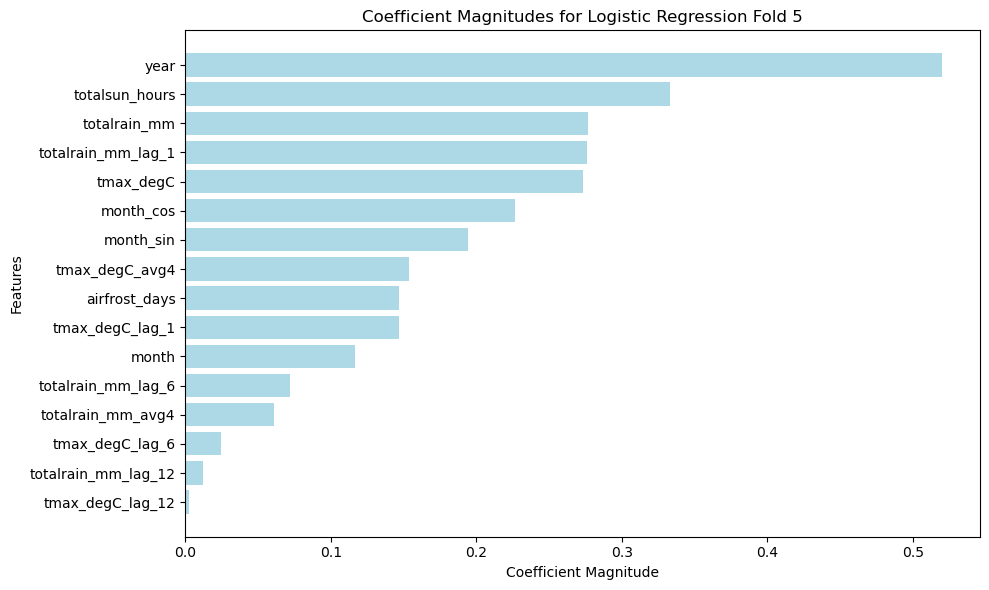

In [51]:
import matplotlib.pyplot as plt
import numpy as np

sorted_features = list(logistic_regression_coefficients_fold5.keys())
sorted_coefficients = list(logistic_regression_coefficients_fold5.values())

plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_coefficients, color="lightblue")
plt.xlabel("Coefficient Magnitude")
plt.ylabel("Features")
plt.title("Coefficient Magnitudes for Logistic Regression Fold 5")

# revserse the y-axis so the highest coefficient is at the top
plt.gca().invert_yaxis()

# show the plot
plt.tight_layout()
plt.savefig('logistic_regression_coefficient.png', dpi=300)

plt.show()

Shuffling feature: year
   Shuffled F1 score for year: Mean=0.628, Std=0.014
Shuffling feature: month
   Shuffled F1 score for month: Mean=0.602, Std=0.021
Shuffling feature: tmax_degC
   Shuffled F1 score for tmax_degC: Mean=0.620, Std=0.052
Shuffling feature: airfrost_days
   Shuffled F1 score for airfrost_days: Mean=0.621, Std=0.022
Shuffling feature: totalrain_mm
   Shuffled F1 score for totalrain_mm: Mean=0.563, Std=0.030
Shuffling feature: totalsun_hours
   Shuffled F1 score for totalsun_hours: Mean=0.571, Std=0.025
Shuffling feature: tmax_degC_lag_1
   Shuffled F1 score for tmax_degC_lag_1: Mean=0.610, Std=0.033
Shuffling feature: tmax_degC_lag_6
   Shuffled F1 score for tmax_degC_lag_6: Mean=0.636, Std=0.000
Shuffling feature: tmax_degC_lag_12
   Shuffled F1 score for tmax_degC_lag_12: Mean=0.636, Std=0.000
Shuffling feature: totalrain_mm_lag_1
   Shuffled F1 score for totalrain_mm_lag_1: Mean=0.624, Std=0.039
Shuffling feature: totalrain_mm_lag_6
   Shuffled F1 score for total

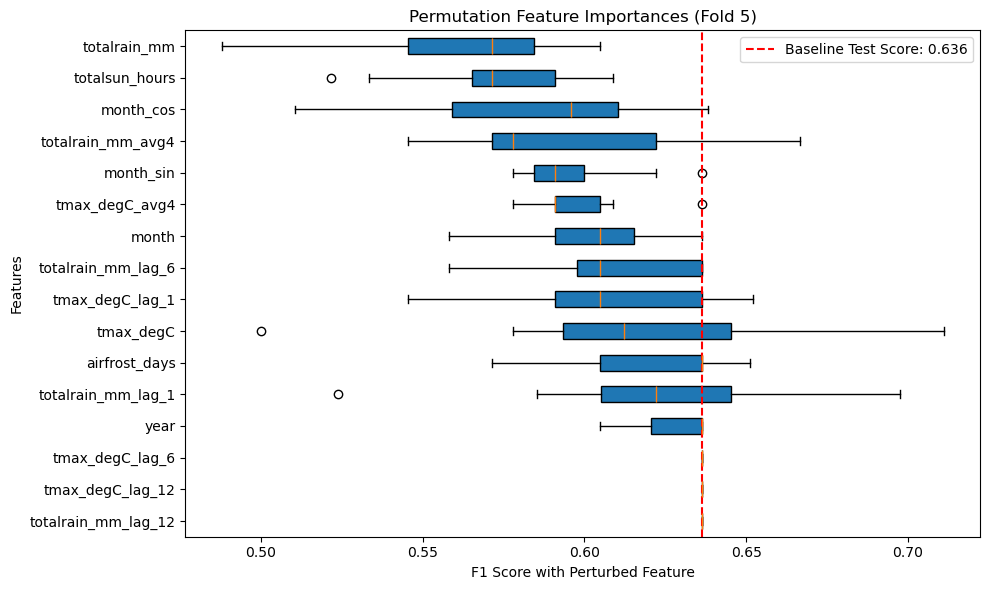

In [54]:
#generate permutation scores & plot

# load in the model, X_test, and Y_test from the pickle file
import pickle
file = open('best_model_fold_5.pickle', 'rb')
model, X_test, Y_test, X_train = pickle.load(file)
file.close()

# calculate the baseline test score (F1 score) using the model on the original X_test
y_pred_baseline = best_model_logistic_regression.predict(X_test)
test_score = f1_score(Y_test, y_pred_baseline)

# initialise dictionary to store the F1 scores after perturbing each feature
perturbed_scores = {}

# set random seed for reproducibility
np.random.seed(10)

# loop through each feature, shuffle it, and calculate the F1 score with the shuffled feature
for feature in X_test.columns:
    print(f"Shuffling feature: {feature}")
    
    # store F1 scores for each shuffle run
    f1_scores = []

    # run the shuffling process 10 times
    for _ in range(15):
        X_test_shuffled = X_test.copy()

        # shuffle the feature values in the X_test dataframe
        X_test_shuffled[feature] = np.random.permutation(X_test_shuffled[feature])

        # predict using the shuffled data
        y_pred_shuffled = best_model_logistic_regression.predict(X_test_shuffled)

        # calculate F1 score for the shuffled data
        f1_shuffled = f1_score(Y_test, y_pred_shuffled)
        f1_scores.append(f1_shuffled)

    # store the F1 scores for the perturbed feature
    perturbed_scores[feature] = f1_scores

    # print the shuffled F1 score for this feature
    print(f"   Shuffled F1 score for {feature}: Mean={np.mean(f1_scores):.3f}, Std={np.std(f1_scores):.3f}")

# prepare data for plotting (F1 scores for each feature)
feature_names = list(perturbed_scores.keys())
shuffled_scores = list(perturbed_scores.values())

# sort features based on the mean F1 score difference from the baseline
sorted_indcs = np.argsort([np.mean(scores) for scores in shuffled_scores])[::-1]  # Sort by mean F1 score in descending order

# sorted values for plotting
sorted_feature_names = np.array(feature_names)[sorted_indcs]
sorted_shuffled_scores = np.array(shuffled_scores)[sorted_indcs]

# plotting the results
plt.figure(figsize=(10, 6))

# create the boxplot for each feature's shuffled F1 scores (sorted)
plt.boxplot(sorted_shuffled_scores.tolist(), vert=False, patch_artist=True, tick_labels=sorted_feature_names)

# add vertical line for the baseline test score
plt.axvline(test_score, color='red', linestyle='--', label=f'Baseline Test Score: {test_score:.3f}')

# add title and labels
plt.title("Permutation Feature Importances (Fold 5)")
plt.xlabel("F1 Score with Perturbed Feature")
plt.ylabel("Features")
plt.legend()

# adjust layout and show the plot
plt.tight_layout()

# save the plot
plt.savefig('permutation_importances_boxplots.png', dpi=300)

plt.show()


Expected value (base value) for model: 0.546175448388251


<Figure size 3000x800 with 0 Axes>

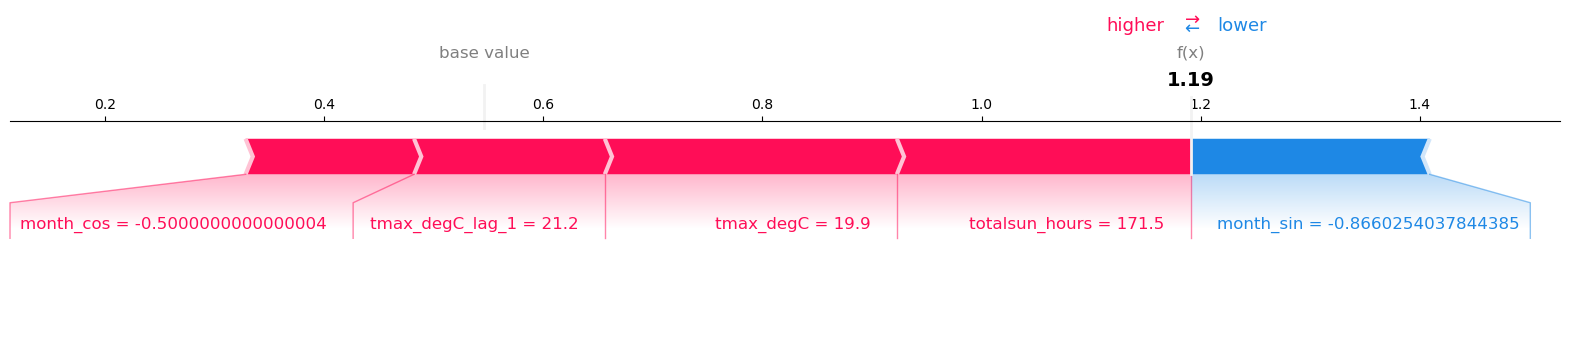

In [56]:
#generate force plot for different index

# load the best model and the test set for fold 5
with open('best_model_fold_5.pickle', 'rb') as file:
    model, X_test, Y_test, X_train = pickle.load(file)

# logistic Regression inside pipeline
best_model_logistic_regression = model['model']

# initialise StandardScaler
scaler = StandardScaler()

scaler.fit(X_train)  # Fit scaler on training data

# transform X_test using the fitted scaler
X_test_transformed = scaler.transform(X_test)

# SHAP explainer for the logistic regression model
explainer = shap.LinearExplainer(best_model_logistic_regression, X_test_transformed, model_output="probability")

# calculate SHAP values for the entire test set
shap_values = explainer(X_test_transformed)

# choosing index in X_test
index = 3
shap_values_for_index = shap_values[index]

# print expected value (base value) for this model (the baseline prediction)
print(f"Expected value (base value) for model: {explainer.expected_value}")

sorted_indices = np.argsort(np.abs(shap_values_for_index.values))[-5:]  # get top 5 features

# get top 5 SHAP values and their corresponding features
top_shap_values = shap_values_for_index.values[sorted_indices]
top_feature_names = X_test.columns[sorted_indices]

# plot SHAP values for the specific instance
shap.initjs() 

plt.figure(figsize=(30, 8))

# plotting the force plot with SHAP values for this instance
shap.force_plot(
    shap_values_for_index.base_values,    # expected base value (model's baseline output)
    top_shap_values,         # SHAP values (feature contributions)
    X_test.iloc[index, sorted_indices],
    feature_names=top_feature_names,
    matplotlib=True,
    show=True
)

#plt.savefig(f"shap_force_plot_instance_{index}_fold_5.png", bbox_inches='tight', dpi=300)

plt.close()
